In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANNDL-H1/

Mounted at /gdrive
/gdrive/My Drive/ANNDL-H1


# Stuff Tried For Model2
- **model2_Base** -> 55%
- **model2_BatchNormalization** -> 60% accuracy
- **model2_GlobalAvgpooling1** -> Accuracy: 0.6751,Precision: 0.651,Recall: 0.6307,F1: 0.6353
- **model2_GlobalAvgpooling3** -> AccurAccuracy: 0.6469,Precision: 0.6141,Recall: 0.5935,F1: 0.5984
- **model2_GlobalAvgpooling4_MaxPooling** -> AccurAccuracy: 0.655,Precision: 0.6095,Recall: 0.0.6006,F1: 0.6000
- **model2_GlobalAvgpooling4_Batch(no multiConv)**-> AccurAccuracy: 0.678,Precision: 0.6658,Recall: 0.0.6449,F1: 0.6241
- **model2_GlobalAvgpooling6_BestVersion(added batch between dense)**-> AccurAccuracy: 0.6808,Precision: 0.6414,Recall: 0.0.6306,F1: 0.6299 


BAD: Double CONV on first,second layer dosnt work\
BAD: Triple CONV on third and forth dosnt work (stuck to 10%)\
BAD: Droppout after global avg pooling dosnt work\
BAD: Batch Normalization on Convolutions dosnt work well\


In [16]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
#!pip install visualkeras
import visualkeras
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
%load_ext autoreload
%autoreload 2

2.10.1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('../../../Utils/')
from DatasetHelper import DatasetHelper
from ModelHelper import ModelHelper

## Helper Configuration:
Configure
 the helper classes by setting a seed and the root folder path

In [3]:
#Create Instances Of Utils Helper
seed = 42
labels = {0:'Species1', 1:'Species2', 2:'Species3', 3:'Species4',4:'Species5', 5:'Species6', 6:'Species7', 7:'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("../../",42) #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper   = ModelHelper("../../",labels) #take in input local models folder and lables
model_helper.create_seed(tf,seed);

# Dataset Loading and Preprocessing

Load dataset and apply all the preprocessing operations
- Splitting
- Normalization
- Augmentation

In [4]:
#Load Dataset
X,Y = dataset_helper.load_dataset_from_numpy()
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * X.shape[0]),stratify = Y)

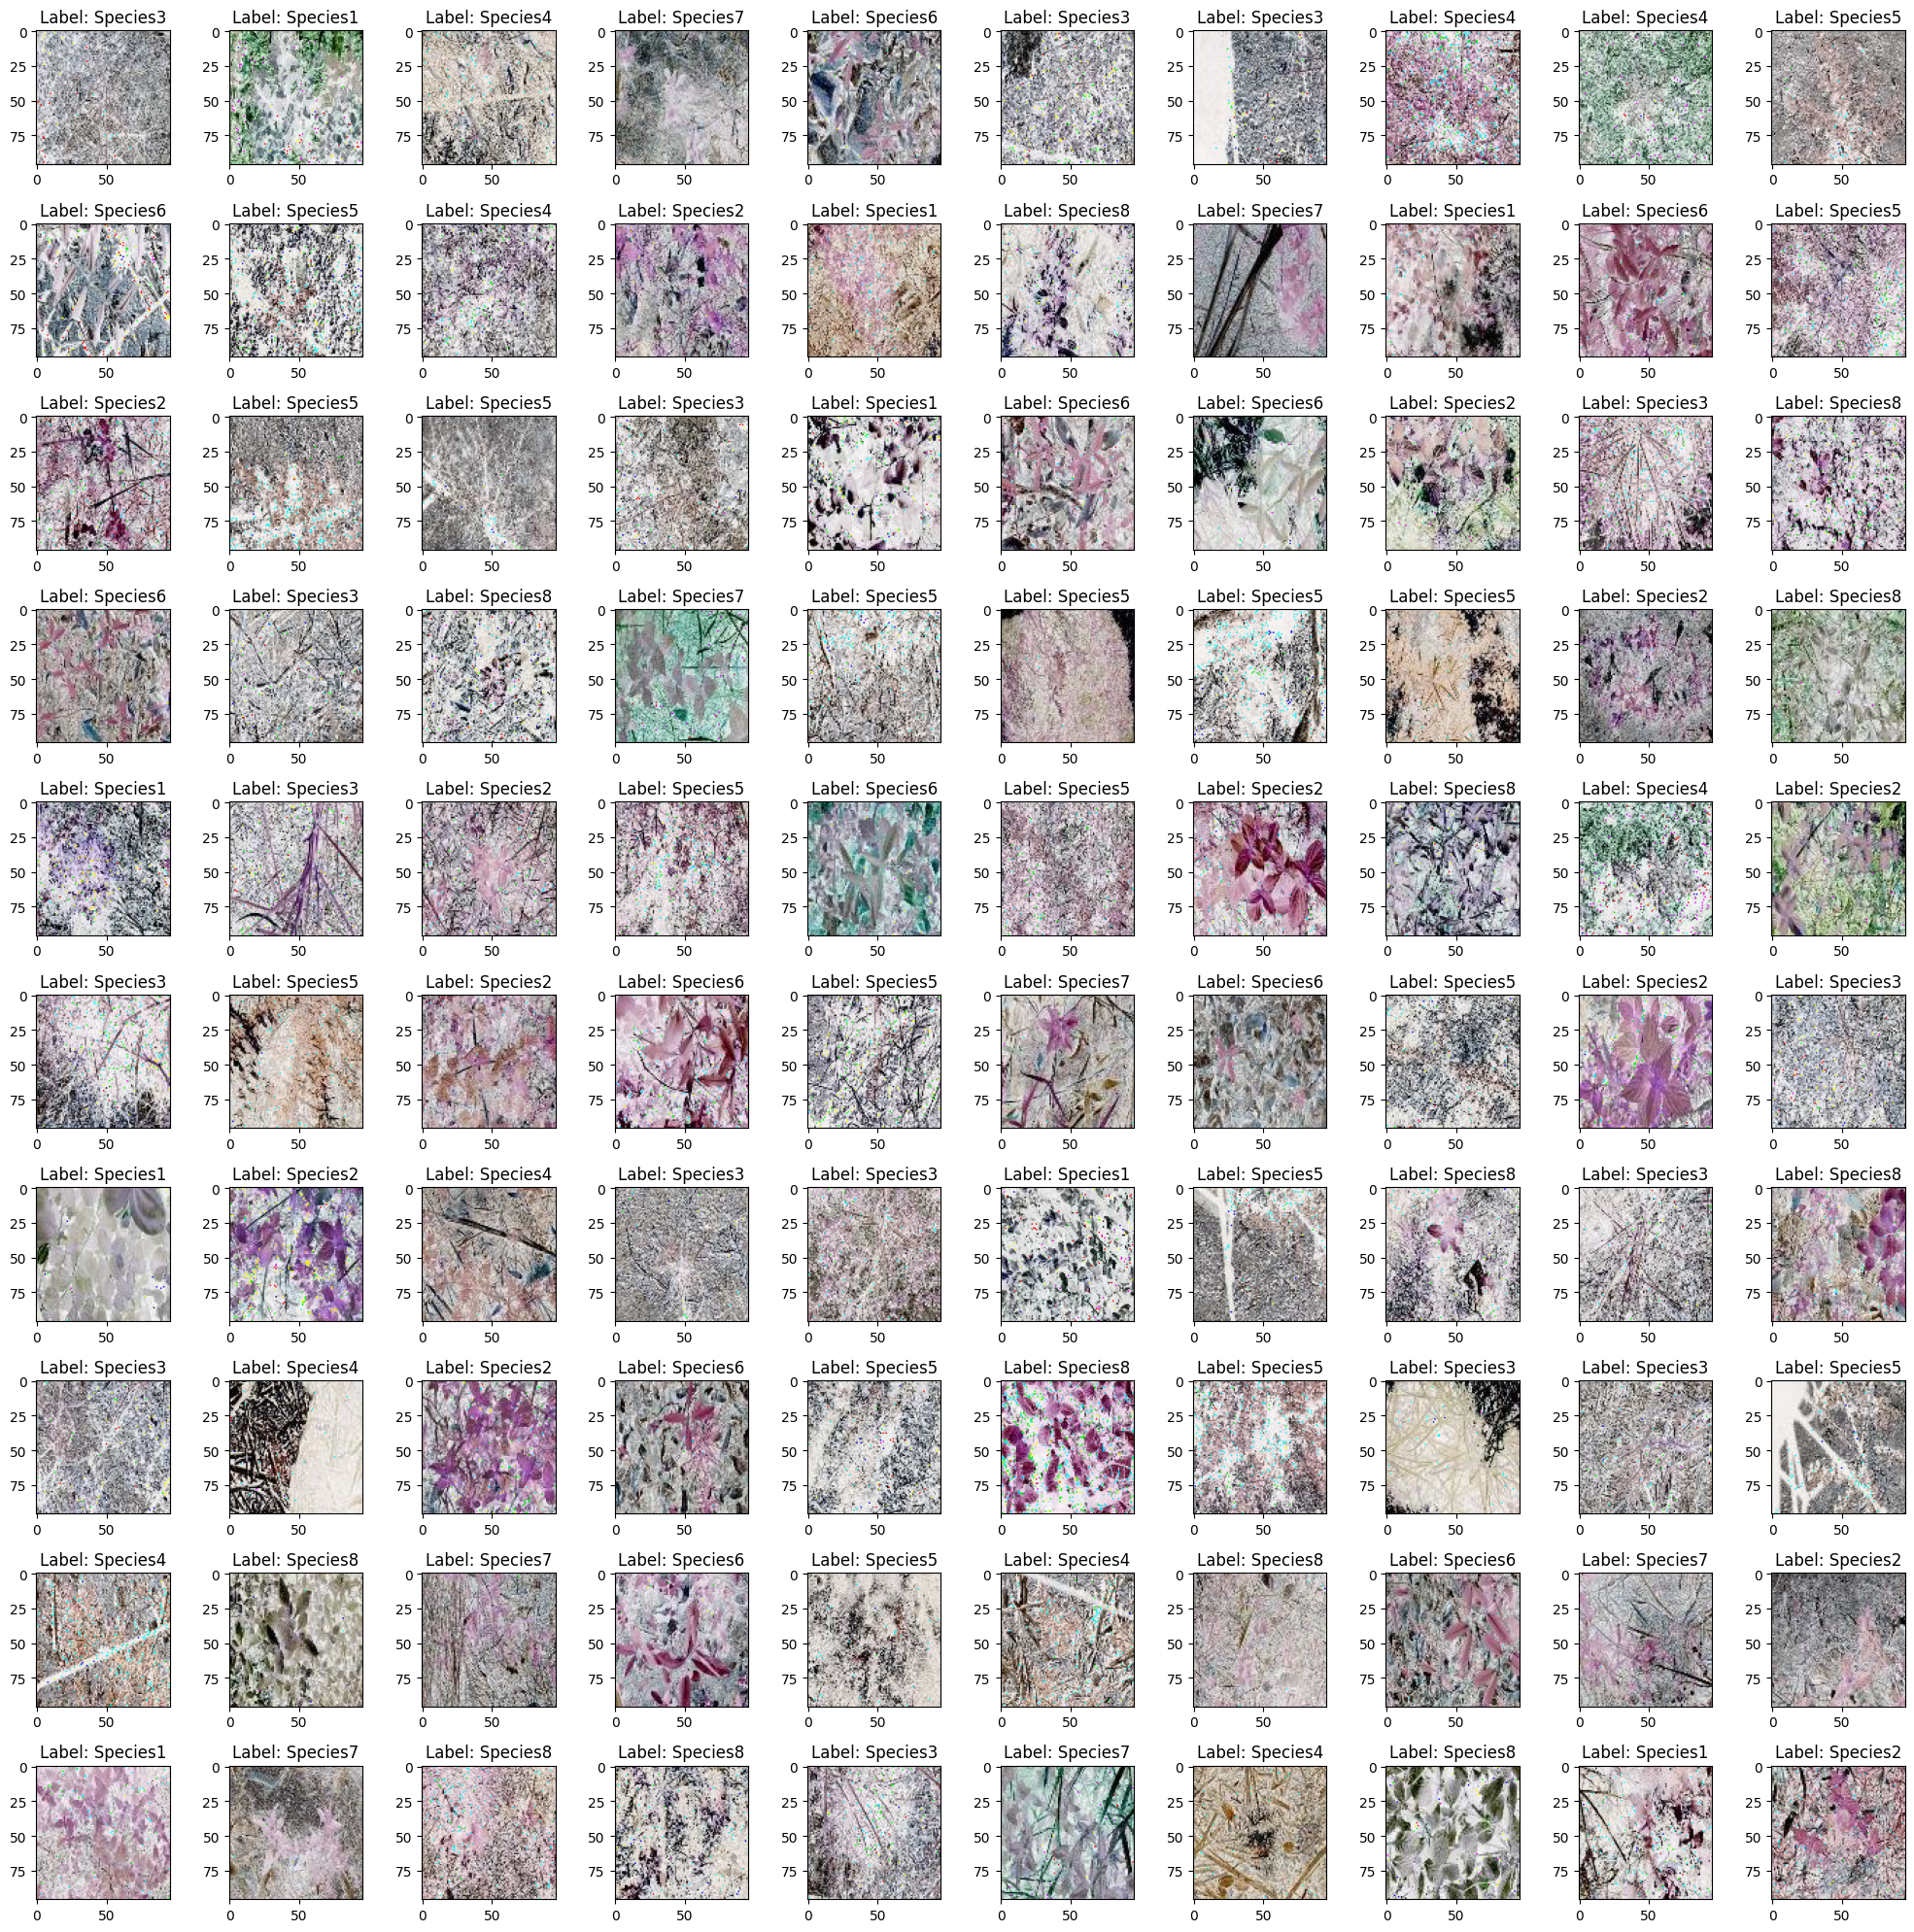

In [31]:
start = 3000
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 10
classe = 2
filter_classes = False
for i in range(1, columns*rows +1):
    if not (filter_classes) or np.argmax(Y_train[start+i]) == classe:
        subplot = fig.add_subplot(rows, columns, i)
        subplot.title.set_text('Label: '+ labels[np.argmax(Y_train[start+i])])
        plt.imshow((X_train[start+i]*255).astype(np.uint8))
    else:
        i=i-1
fig.tight_layout()
plt.show()

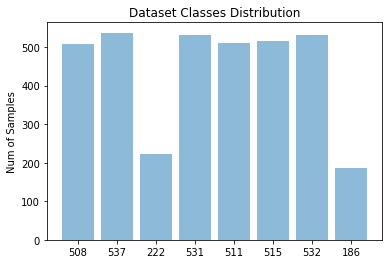

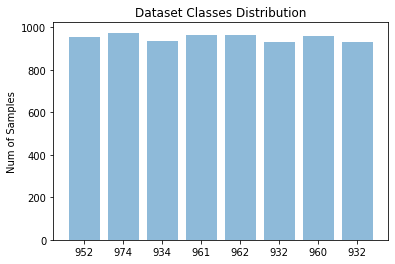

In [ ]:
dataset_helper.plot_samples_distribution(Y)
dataset_helper.plot_samples_distribution(Y_train)

# Define the model Structure
Create a function that declare all the model components

In [5]:
def stackDenseLayer(layer_name,last_layer,size=256, activation='relu', drop_out = False,drop_rate=0.5,GlorthUniform=False,batch_normalization=False):
    initializer = tfk.initializers.HeUniform(seed)
    if GlorthUniform:
      initializer = tfk.initializers.GlorotUniform(seed)

    dense_layer = tfkl.Dense(
        units=size, 
        name=layer_name, 
        activation=activation,
        kernel_initializer = initializer #Can Be HeUniform(seed) or GlorotUniform(seed)
    )(last_layer)

    #If desired, apply batch normalization
    if batch_normalization:
      dense_layer = tfkl.BatchNormalization(
            axis=-1,
            momentum=0.99,
            epsilon=0.001,
            center=True,
            scale=True,
            beta_initializer="zeros",
            gamma_initializer="ones",
            moving_mean_initializer="zeros",
            moving_variance_initializer="ones"
        )(dense_layer)
    #If desired add droppout
    if drop_out:
        dense_layer = tfkl.Dropout(drop_rate, seed=seed)(dense_layer)
    
    return dense_layer


In [6]:
def stackConvolutionLayer(layer_name,last_layer,kernel_size = (3,3), num_of_filter = 32,strides= (1,1),activation = 'relu',padding = 'same',pooling_size=(2,2),batch_normalization=False,num_of_stacked_conv=1,Pool=True,PoolAvg=False):
    layer_activation = activation
    
    for i in range(0,num_of_stacked_conv):
        curr_name = layer_name + "_conv" + str(i)
        
        if batch_normalization and i == num_of_stacked_conv - 1:
            activation = None

        curr_conv =tfkl.Conv2D(
            filters=num_of_filter,
            kernel_size=kernel_size,
            strides = strides,
            padding = padding,
            activation = layer_activation,
            name=curr_name,
            kernel_initializer = tfk.initializers.HeUniform(seed)
        )(last_layer)

        if batch_normalization and i == num_of_stacked_conv-1: #Batch  true and last conv in layer
            batch = BatchNormalization()(curr_conv)
            activation = tfkl.Activation(layer_activation)(batch)
            curr_conv = activation

        last_layer = curr_conv

        if Pool:
          if PoolAvg:
            curr_conv = tfkl.AvgPool2D(pool_size = pooling_size)(last_layer)
          else:
            curr_conv = tfkl.MaxPooling2D(pool_size = pooling_size)(last_layer)

          

    return curr_conv

In [75]:
from tensorflow.keras import layers
#Create the Model
def build_model(input_shape,model_name):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    layer_0 = stackConvolutionLayer('Layer0',input_layer,kernel_size=(7,7),num_of_filter=32,num_of_stacked_conv = 1,batch_normalization=False)

    layer_1 = stackConvolutionLayer('Layer1',layer_0,kernel_size=(5,5),num_of_filter=64,num_of_stacked_conv = 1,batch_normalization=False)

    layer_2 = stackConvolutionLayer('Layer2',layer_1,kernel_size=(3,3),num_of_filter=128,num_of_stacked_conv = 1,batch_normalization=False)
    
    layer_3 = stackConvolutionLayer('Layer3',layer_2,kernel_size=(3,3),num_of_filter=256,num_of_stacked_conv = 1,batch_normalization=False)
    
    #flattening_layer_global_pool = tfkl.GlobalAveragePooling2D(name='GlobalAVGPool')(layer_3)
    flattening_layer = tfkl.Flatten(name='Flatten')(layer_3)
    flattening_layer_global_pool = tfkl.Dropout(0.3, seed=seed, name='gap_dropout')(flattening_layer)
  
    classifier_layer0   = stackDenseLayer('Classifier_layer0',flattening_layer_global_pool ,size=256,drop_out=True,drop_rate=0.3,batch_normalization = False,GlorthUniform = True)

    output_layer = stackDenseLayer('Output',classifier_layer0,size=2,activation='softmax',GlorthUniform = True)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name=model_name)

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [44]:
def train_ensemble_classifier(class_index,input_shape,seed = 42):
    #Split dataset into "class i" vs "others" (BINARY)
    curr_y = dataset_helper.get_class_i_vs_other(X_train,Y_train,class_index)
    dataset_helper.plot_samples_distribution(curr_y)

    curr_x,curr_x_test,curr_y,curr_y_test = train_test_split(X_train, curr_y, random_state=seed, test_size=int(0.1 * X.shape[0]),stratify = curr_y)
    curr_x,curr_x_val,curr_y,curr_y_val   = train_test_split(curr_x, curr_y, random_state=seed, test_size=int(0.1 * X.shape[0]),stratify = curr_y)

    #Apply Augmentation
    augmentation_size = 5000
    curr_x,curr_y = dataset_helper.apply_data_augmentation_with_classes_distribution(X, curr_y,
                                                          augmentation_size, class_distribution = [0.45, 0.2],
                                                          norm_mode=1, disable_tqdm=True,
                                                          rotation_range=180, width_shift_range=0.1, 
                                                          height_shift_range=0.1, zoom_range=0.3, 
                                                          fill_mode="reflect", brightness_range=(0.5, 1.1),
                                                          horizontal_flip=True,
                                                          vertical_flip=True,
                                                          
                                                          )

    #Normalize
    curr_x      = curr_x/255
    curr_x_test = curr_x_test/255
    curr_x_val  = curr_x_val/255
    
    dataset_helper.plot_samples_distribution(curr_y)

    model_name = "ensemble-" + str(class_index)

    #TODO SPLIT DATA IN VALIDATION AND TEST
    model_i = build_model(input_shape,model_name)
    model_i.summary()
    
    # Train the model
    #Create ALL desired callbacks
    callbacks_selected = model_helper.createCallbacks(earlyStopping = True,checkPoints=True,patience=10)

    #Fit the model
    history = model_i.fit(
        x = curr_x,
        y = curr_y,
        batch_size = 128,
        epochs = 200,
        validation_data = (curr_x_val, curr_y_val),
        callbacks = callbacks_selected
    ).history

    model_helper.show_confusion_matrix(curr_x_test,curr_y_test)
    model_helper.plot_phase_train_vs_validation(history)

    model_helper.save_model(model_i,model_name)
    return model_i
    

In [74]:
#Build the model
input_shape = X_train.shape[1:]#(None,96,96,3)
batch_size = 128
epochs = 200

ensemble_model = []
class_index = 1

Class in i:  (167,)
Class in others:  (3021,)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


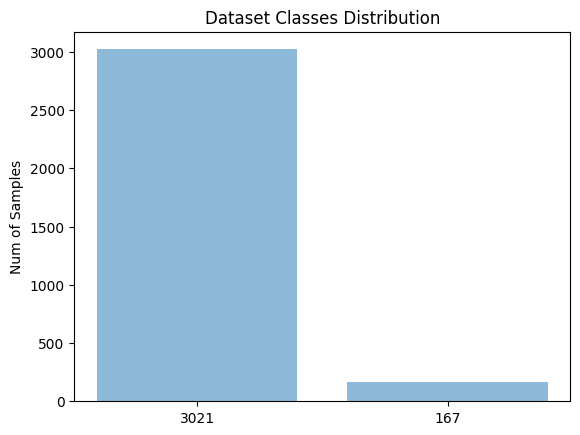

In [76]:
#Split dataset into "class i" vs "others" (BINARY)
curr_y = dataset_helper.get_class_i_vs_other(X_train,Y_train,class_index)
print(curr_y)
dataset_helper.plot_samples_distribution(curr_y)

curr_x,curr_x_test,curr_y,curr_y_test = train_test_split(X_train, curr_y, random_state=seed, test_size=int(0.1 * X.shape[0]),stratify = curr_y)
curr_x,curr_x_val,curr_y,curr_y_val   = train_test_split(curr_x, curr_y, random_state=seed, test_size=int(0.1 * X.shape[0]),stratify = curr_y)


Data Augmentation with data distribution
Data distribution = [0.45, 0.2]
Class Size :  131, generating: 2250
1834 images generated
Class Size :  2351, generating: 1000
992 images generated


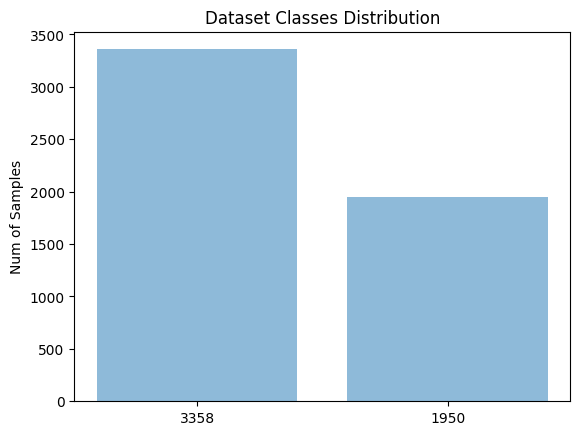

In [77]:
#Apply Augmentation
augmentation_size = 5000
curr_x,curr_y = dataset_helper.apply_data_augmentation_with_classes_distribution(X, curr_y,
                                                          augmentation_size, class_distribution = [0.45, 0.2],
                                                          norm_mode=1, disable_tqdm=True,
                                                          rotation_range=180, width_shift_range=0.1, 
                                                          height_shift_range=0.1, zoom_range=0.3, 
                                                          fill_mode="reflect", brightness_range=(0.5, 1.1),
                                                          horizontal_flip=True,
                                                          vertical_flip=True,
                                                          
                                                          )
#Normalize
curr_x      = curr_x/255
curr_x_test = curr_x_test/255
curr_x_val  = curr_x_val/255

dataset_helper.plot_samples_distribution(curr_y)

In [78]:
model_name = "ensemble-" + str(class_index)

#TODO SPLIT DATA IN VALIDATION AND TEST
model_i = build_model(input_shape,model_name)
model_i.summary()

Model: "ensemble-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 Layer0_conv0 (Conv2D)       (None, 96, 96, 32)        4736      
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 Layer1_conv0 (Conv2D)       (None, 48, 48, 64)        51264     
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 Layer2_conv0 (Conv2D)       (None, 24, 24, 128)       7

In [47]:
!nvidia-smi

Thu Nov 17 10:16:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   31C    P0    72W / 149W |  11099MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [79]:
# Train the model
#Create ALL desired callbacks
callbacks_selected = model_helper.createCallbacks(earlyStopping = True,checkPoints=True,patience=10)

#Fit the model
history = model_i.fit(
        x = curr_x,
        y = curr_y,
        batch_size = 128,
        epochs = 200,
        validation_data = (curr_x_val, curr_y_val),
        callbacks = callbacks_selected
    ).history

Epoch 1/200


ValueError: in user code:

    File "/home/ubuntu/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/ubuntu/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ubuntu/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/ubuntu/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/ubuntu/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/home/ubuntu/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/ubuntu/anaconda3/envs/tf/lib/python3.8/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/ubuntu/anaconda3/envs/tf/lib/python3.8/site-packages/keras/losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/ubuntu/anaconda3/envs/tf/lib/python3.8/site-packages/keras/losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/ubuntu/anaconda3/envs/tf/lib/python3.8/site-packages/keras/backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 2) and (None, 1) are incompatible


12/12 [==============================] - 0s 14ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0


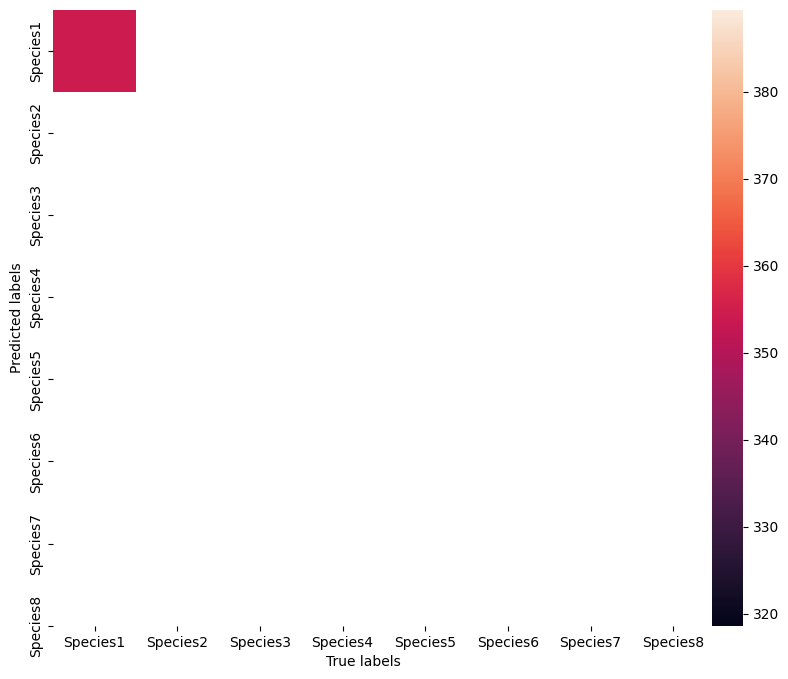

BABABA


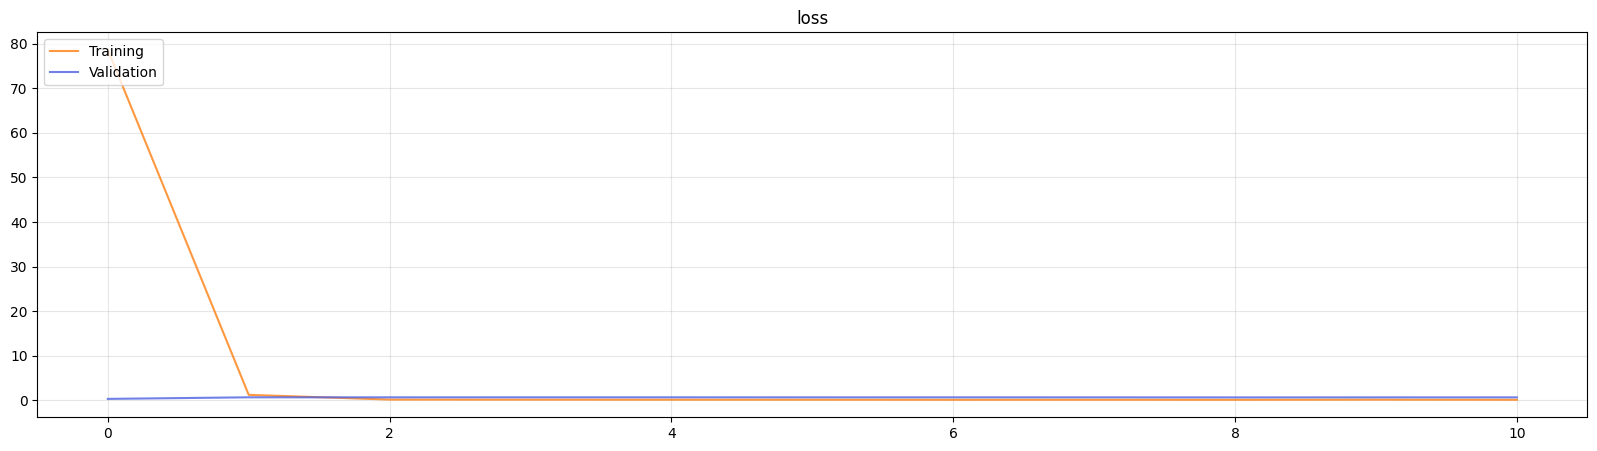

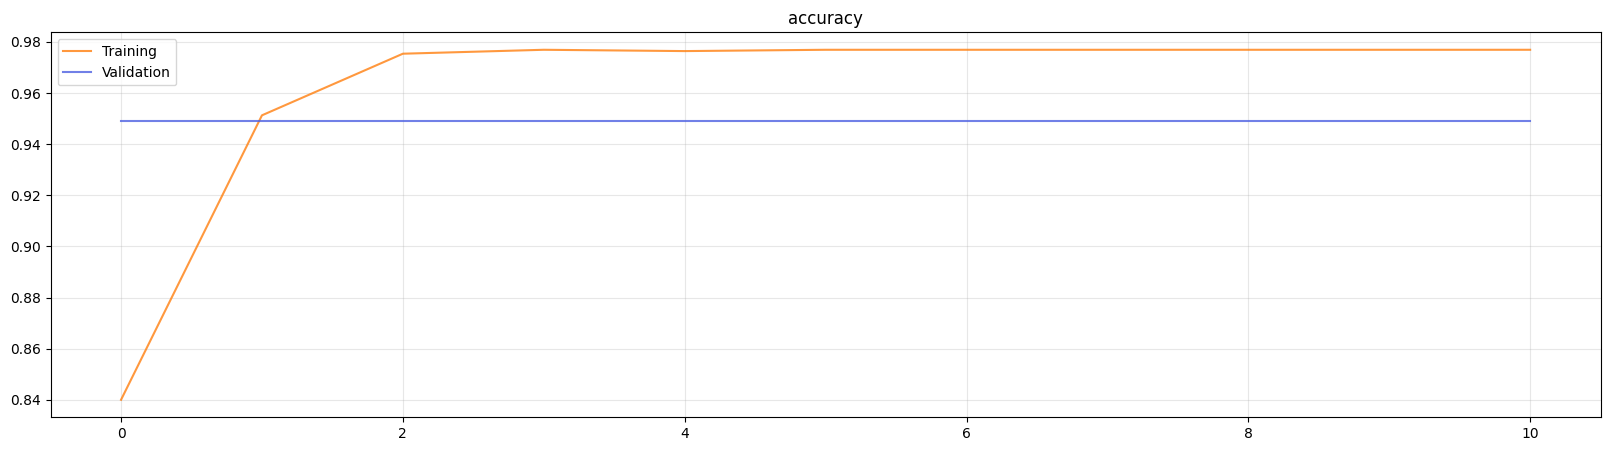

In [49]:
    model_helper.show_confusion_matrix(curr_x_test,curr_y_test,model=model_i)
    model_helper.plot_phase_train_vs_validation(history)

Class in i:  (167,)
Class in others:  (3021,)


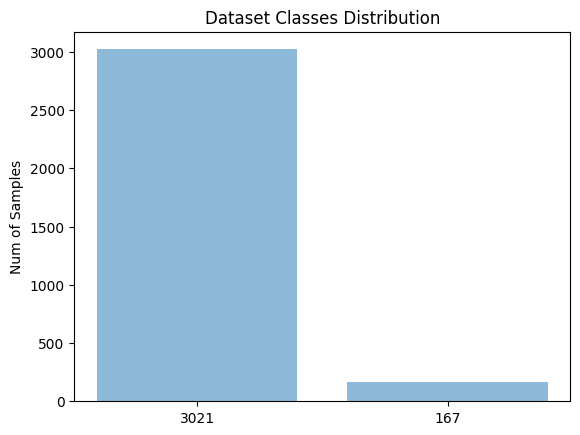

Data Augmentation with data distribution
Data distribution = [0.45, 0.2]
Class Size :  130, generating: 2250
1820 images generated


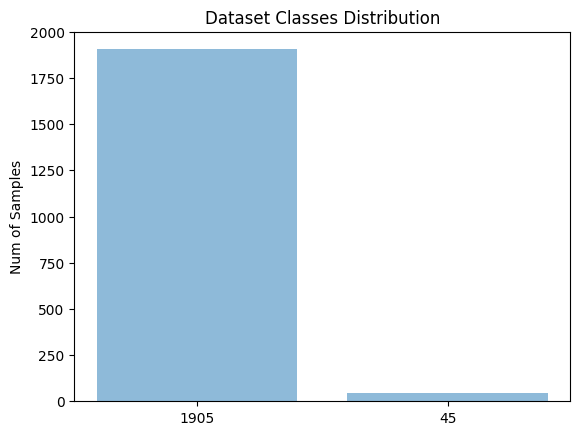

Model: "ensemble-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 Layer0_conv0 (Conv2D)       (None, 96, 96, 32)        4736      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 Layer1_conv0 (Conv2D)       (None, 48, 48, 64)        51264     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 Layer2_conv0 (Conv2D)       (None, 24, 24, 128)       7

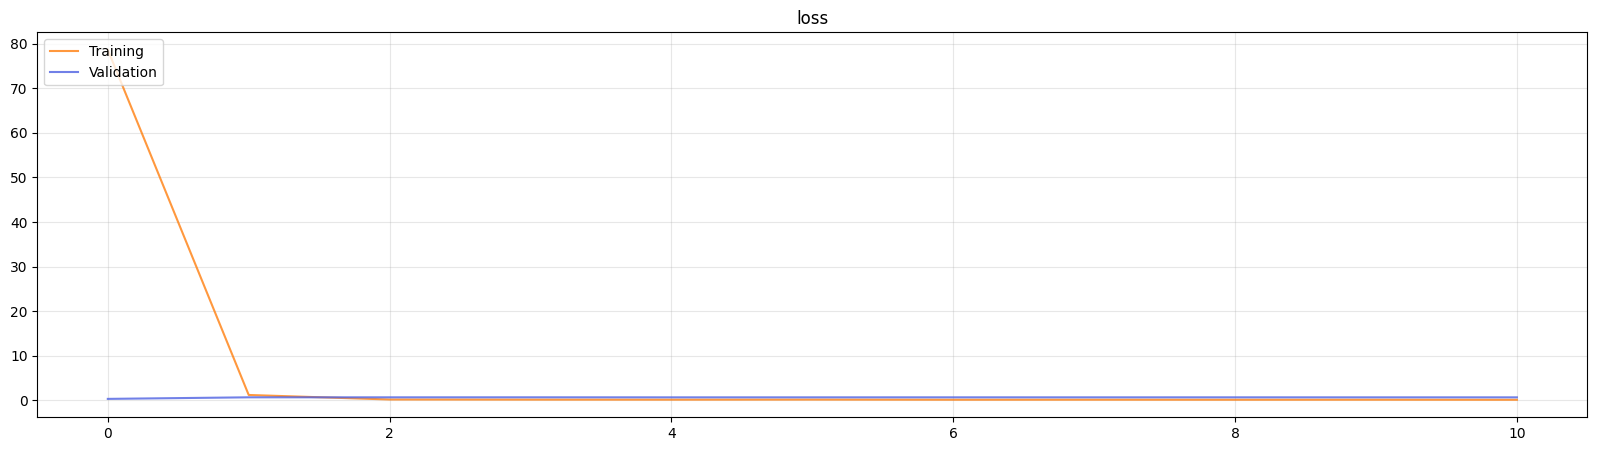

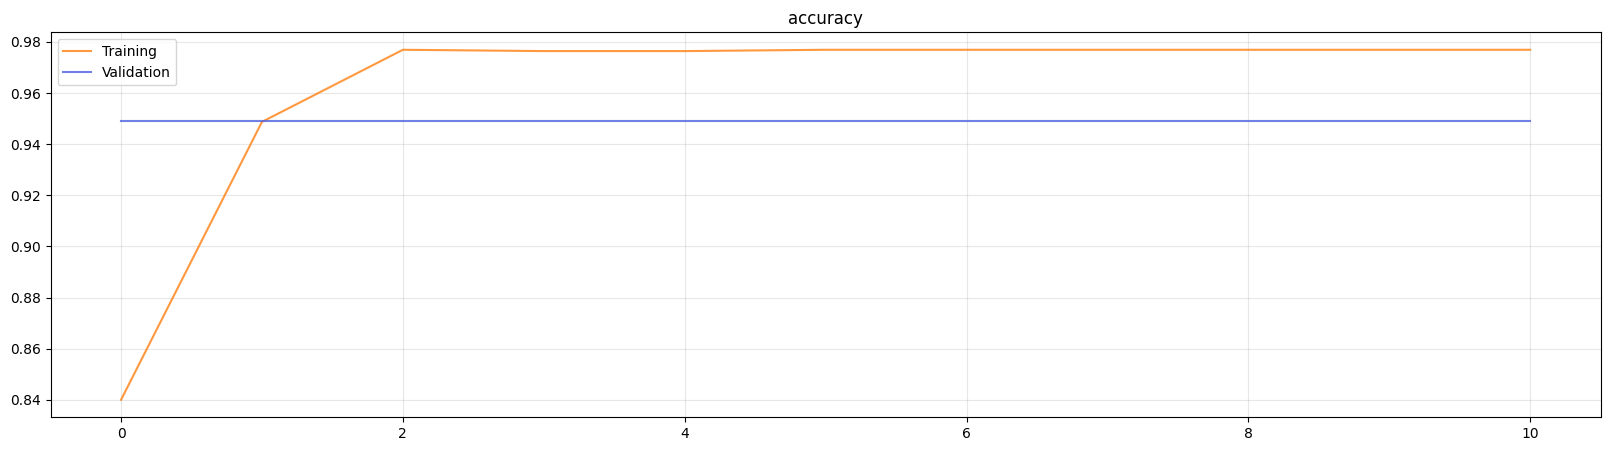

INFO:tensorflow:Assets written to: ../../local_saved_models/ensemble-1/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/ensemble-1/assets


In [50]:
ensemble_model.append(train_ensemble_classifier(1,input_shape))

Class in i:  (479,)
Class in others:  (2709,)


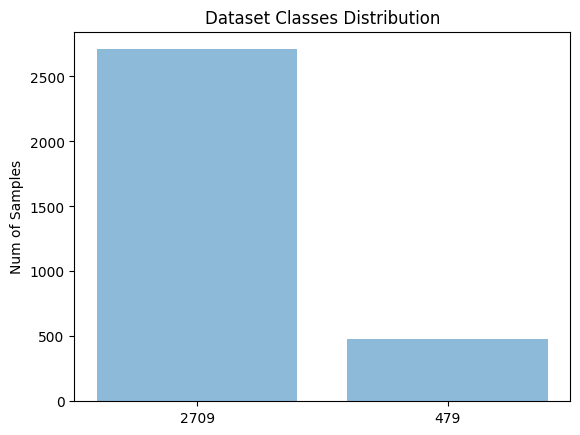

Data Augmentation with data distribution
Data distribution = [0.45, 0.2]
Class Size :  373, generating: 2250
2185 images generated


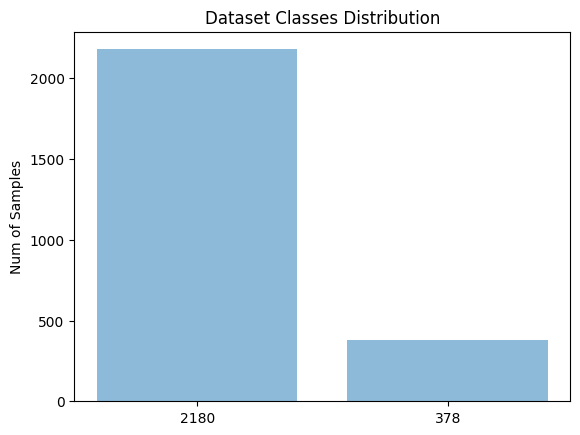

Model: "ensemble-2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 Layer0_conv0 (Conv2D)       (None, 96, 96, 32)        4736      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 Layer1_conv0 (Conv2D)       (None, 48, 48, 64)        51264     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 Layer2_conv0 (Conv2D)       (None, 24, 24, 128)       7

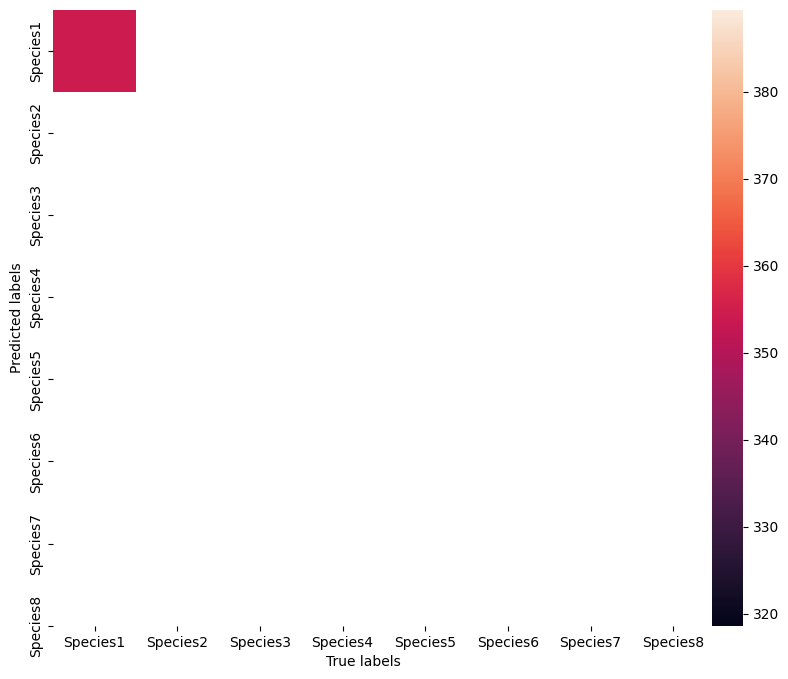

BABABA


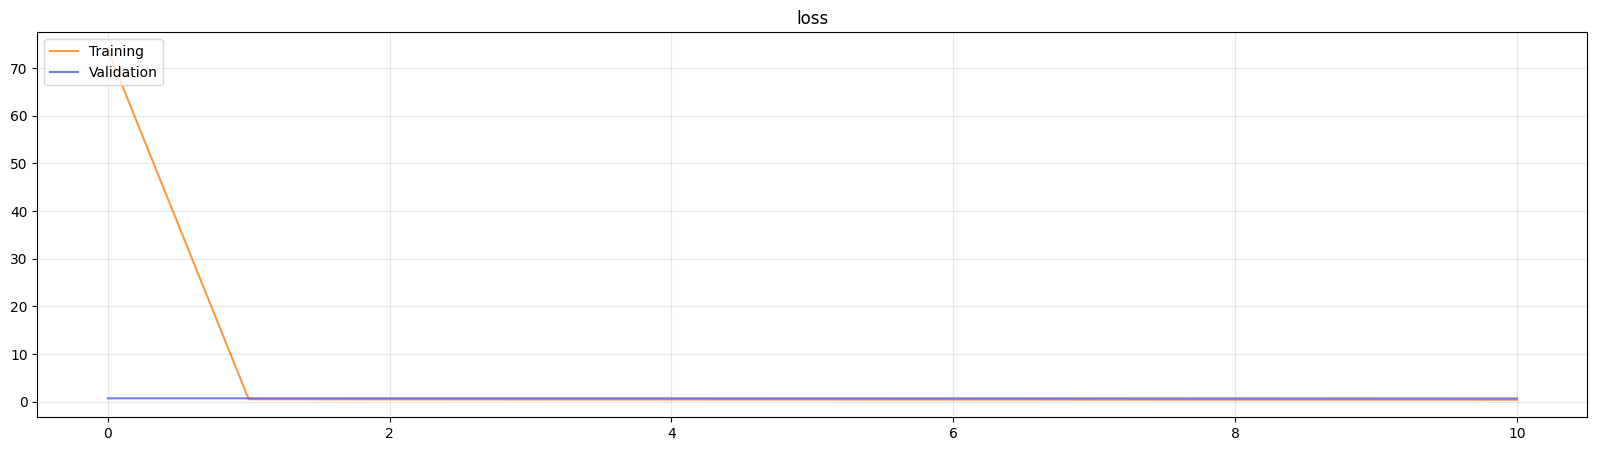

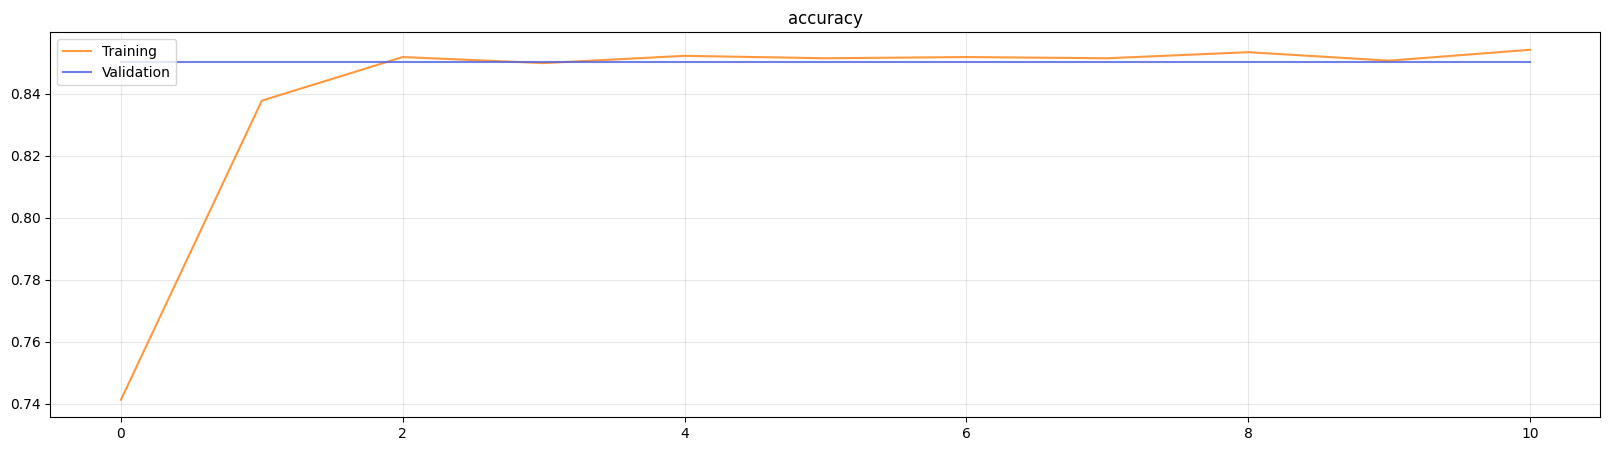

INFO:tensorflow:Assets written to: ../../local_saved_models/ensemble-2/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/ensemble-2/assets


In [52]:
ensemble_model.append(train_ensemble_classifier(2,input_shape))

Class in i:  (464,)
Class in others:  (2724,)


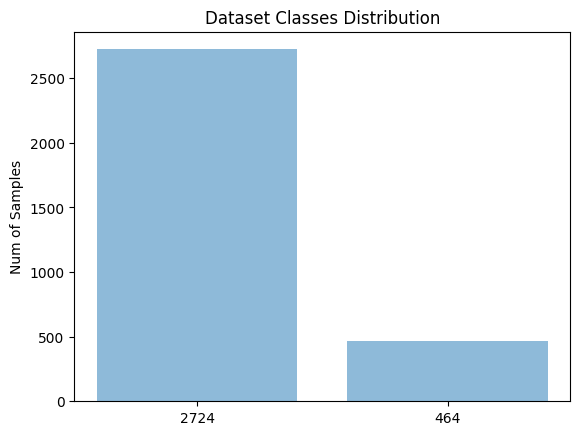

Data Augmentation with data distribution
Data distribution = [0.45, 0.2]
Class Size :  361, generating: 2250
2125 images generated


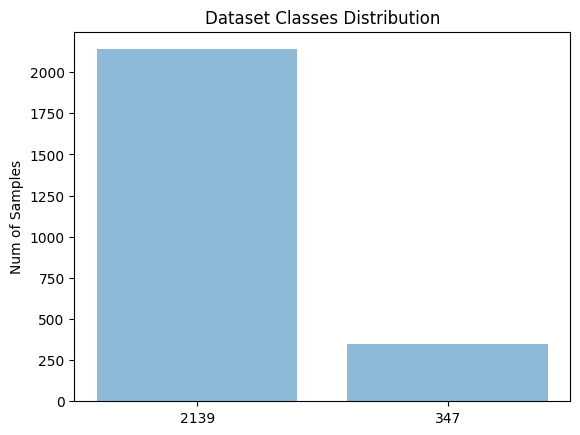

Model: "ensemble-3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 Layer0_conv0 (Conv2D)       (None, 96, 96, 32)        4736      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 Layer1_conv0 (Conv2D)       (None, 48, 48, 64)        51264     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 Layer2_conv0 (Conv2D)       (None, 24, 24, 128)       7

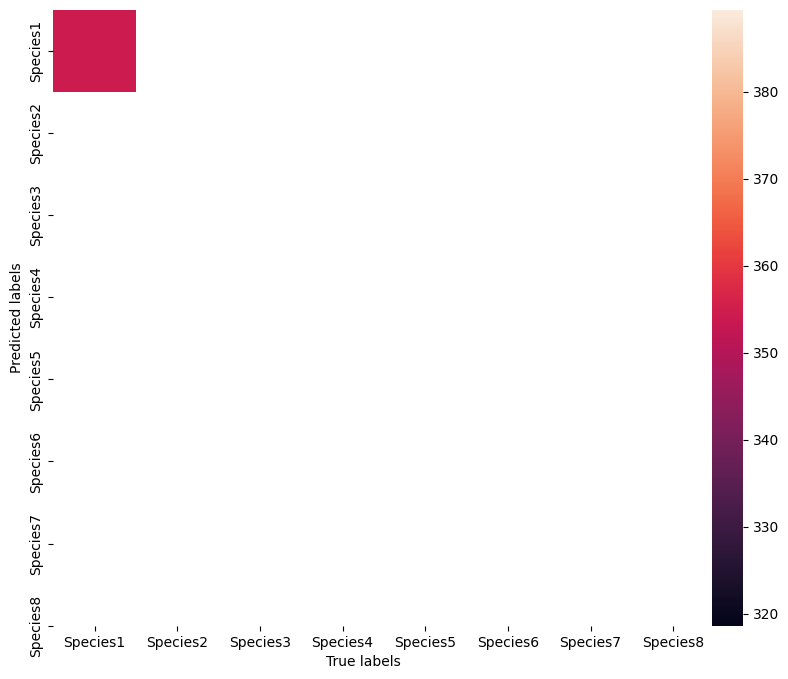

BABABA


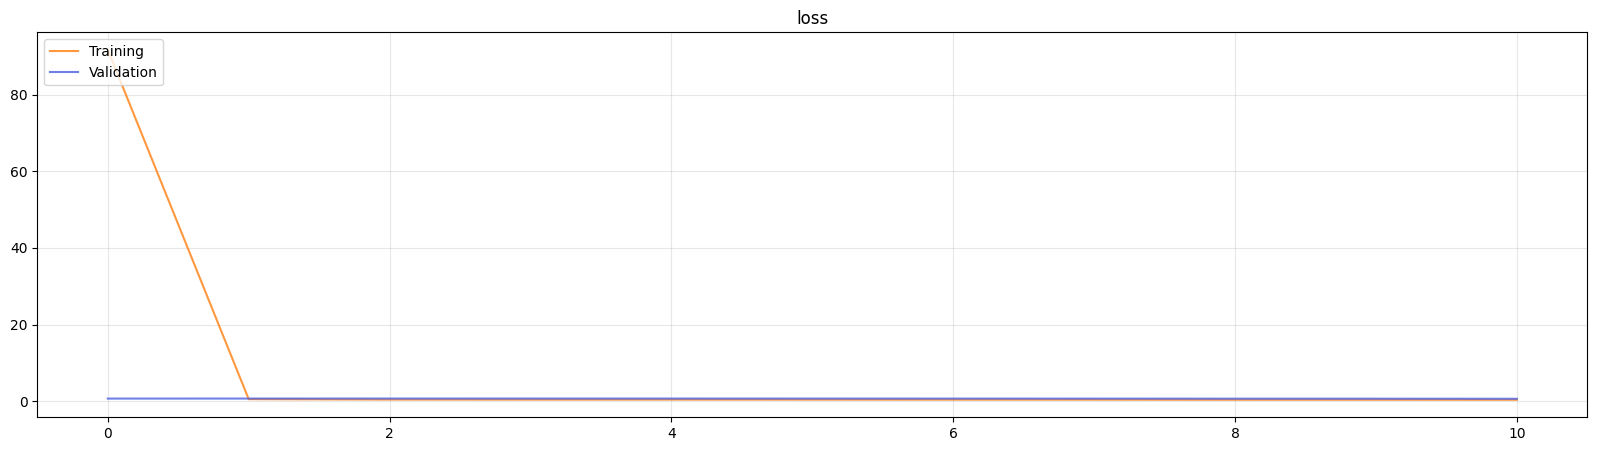

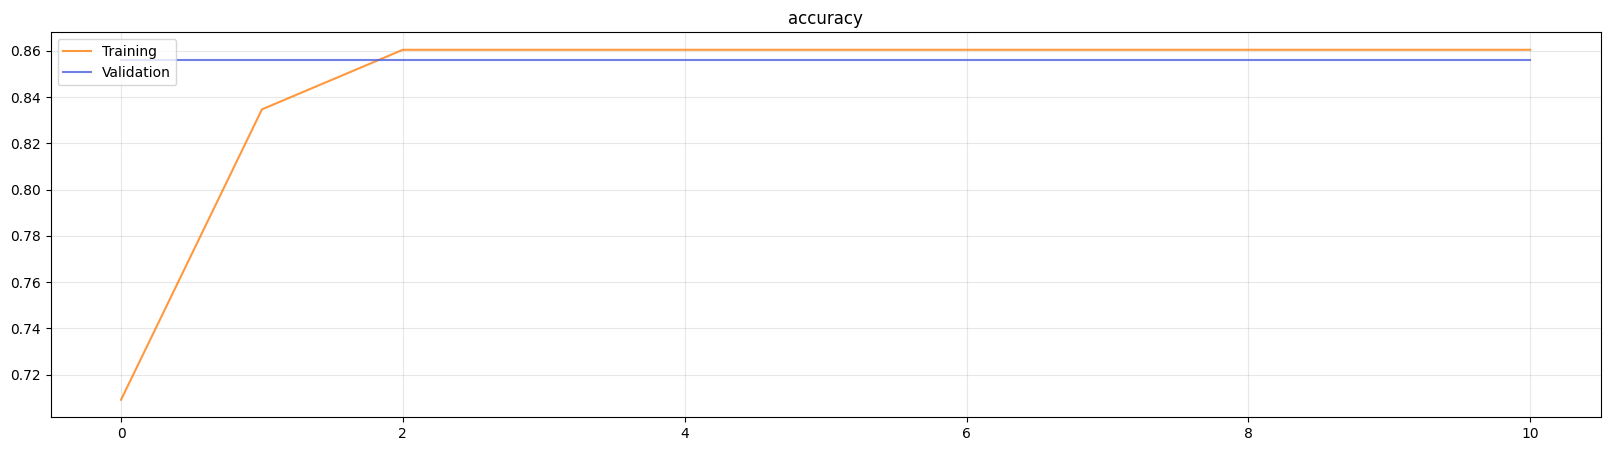

INFO:tensorflow:Assets written to: ../../local_saved_models/ensemble-3/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/ensemble-3/assets


In [53]:
ensemble_model.append(train_ensemble_classifier(3,input_shape))

Class in i:  (460,)
Class in others:  (2728,)


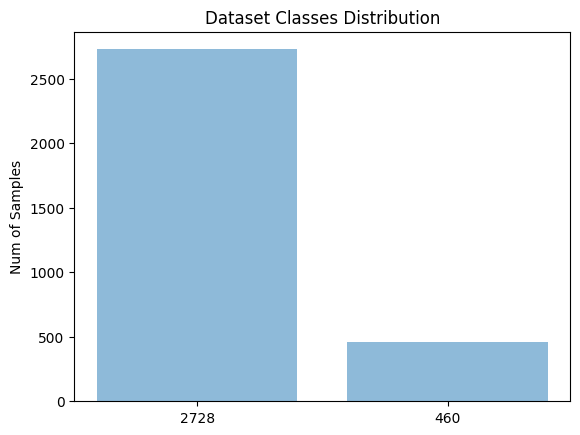

Data Augmentation with data distribution
Data distribution = [0.45, 0.2]
Class Size :  358, generating: 2250
2110 images generated


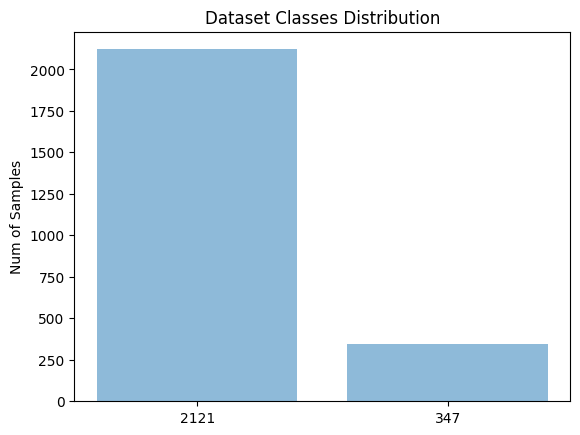

Model: "ensemble-4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 Layer0_conv0 (Conv2D)       (None, 96, 96, 32)        4736      
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 Layer1_conv0 (Conv2D)       (None, 48, 48, 64)        51264     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 Layer2_conv0 (Conv2D)       (None, 24, 24, 128)       7

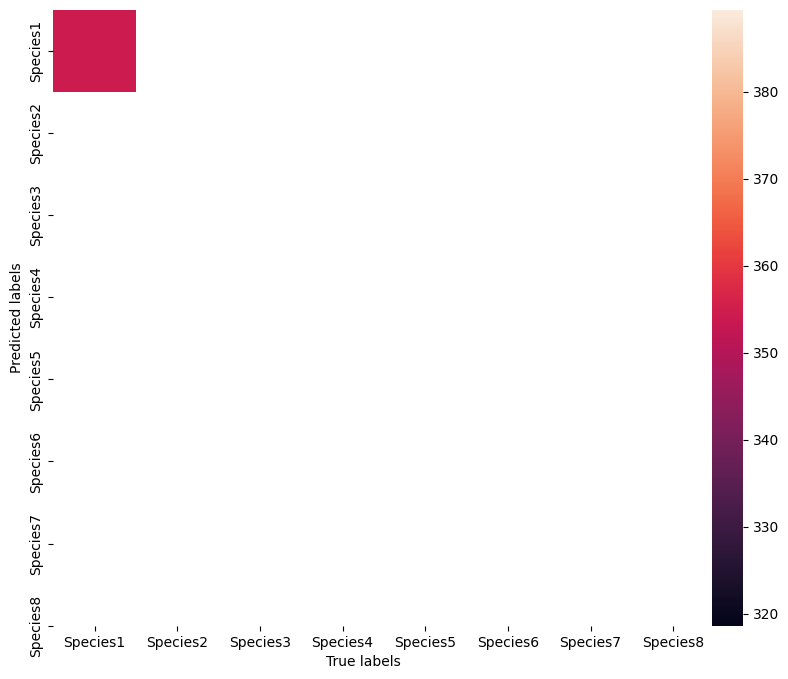

BABABA


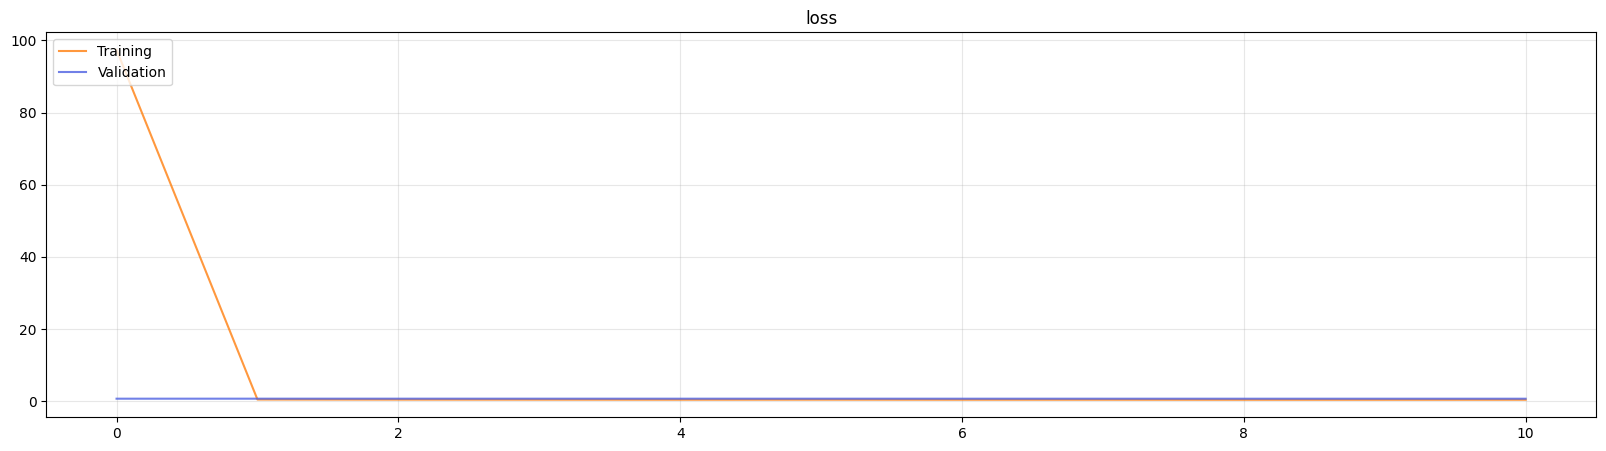

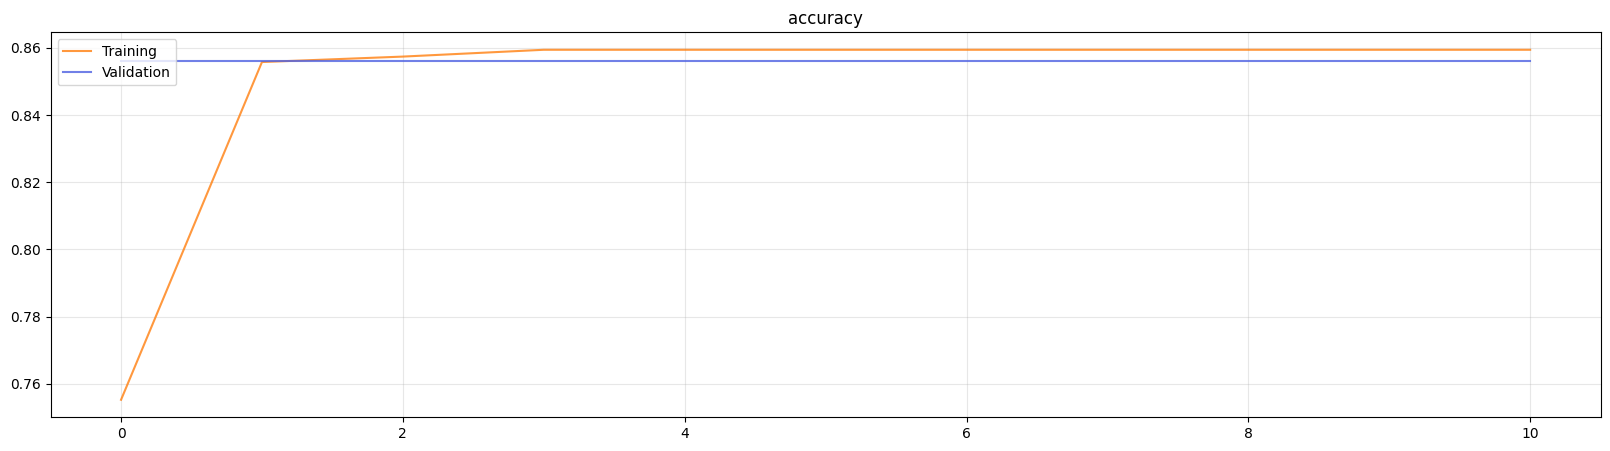

INFO:tensorflow:Assets written to: ../../local_saved_models/ensemble-4/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/ensemble-4/assets


In [54]:
ensemble_model.append(train_ensemble_classifier(4,input_shape))

Class in i:  (478,)
Class in others:  (2710,)


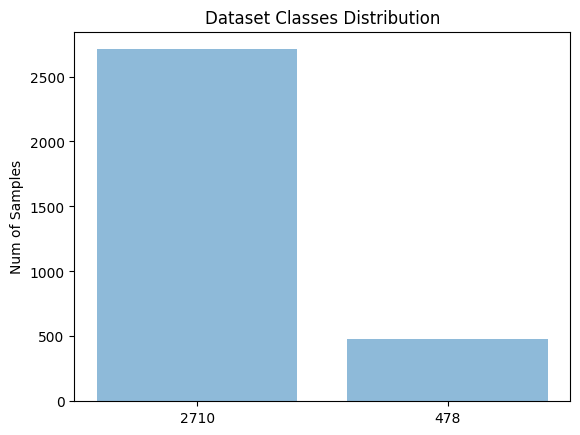

Data Augmentation with data distribution
Data distribution = [0.45, 0.2]
Class Size :  372, generating: 2250
2180 images generated


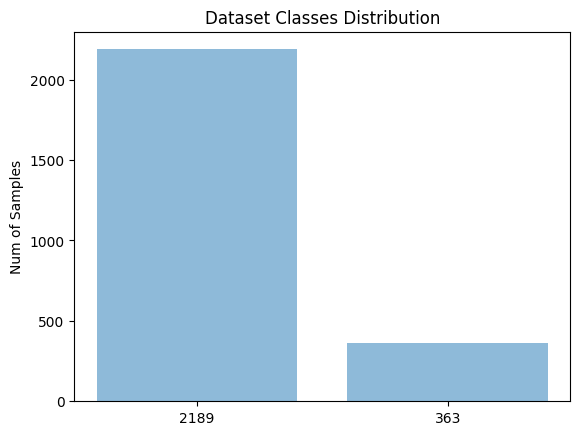

Model: "ensemble-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 Layer0_conv0 (Conv2D)       (None, 96, 96, 32)        4736      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 Layer1_conv0 (Conv2D)       (None, 48, 48, 64)        51264     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 Layer2_conv0 (Conv2D)       (None, 24, 24, 128)       7

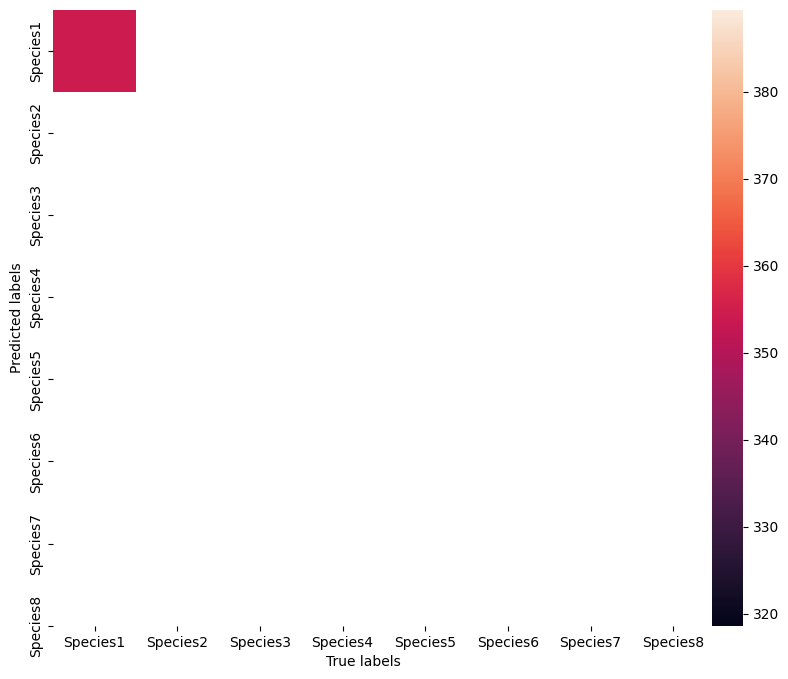

BABABA


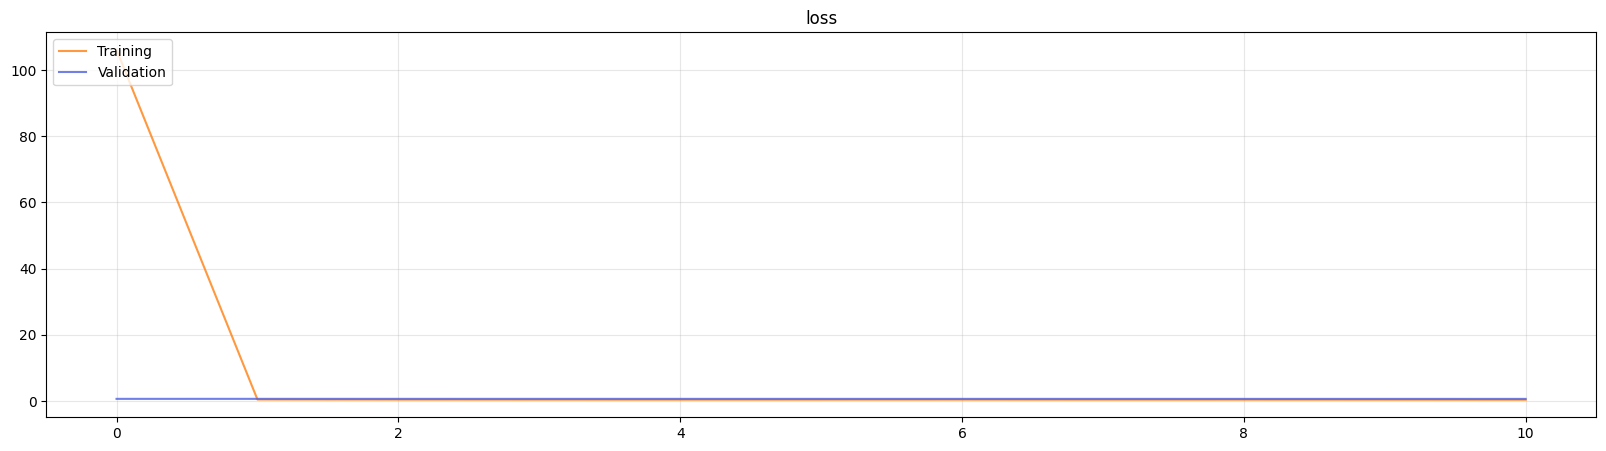

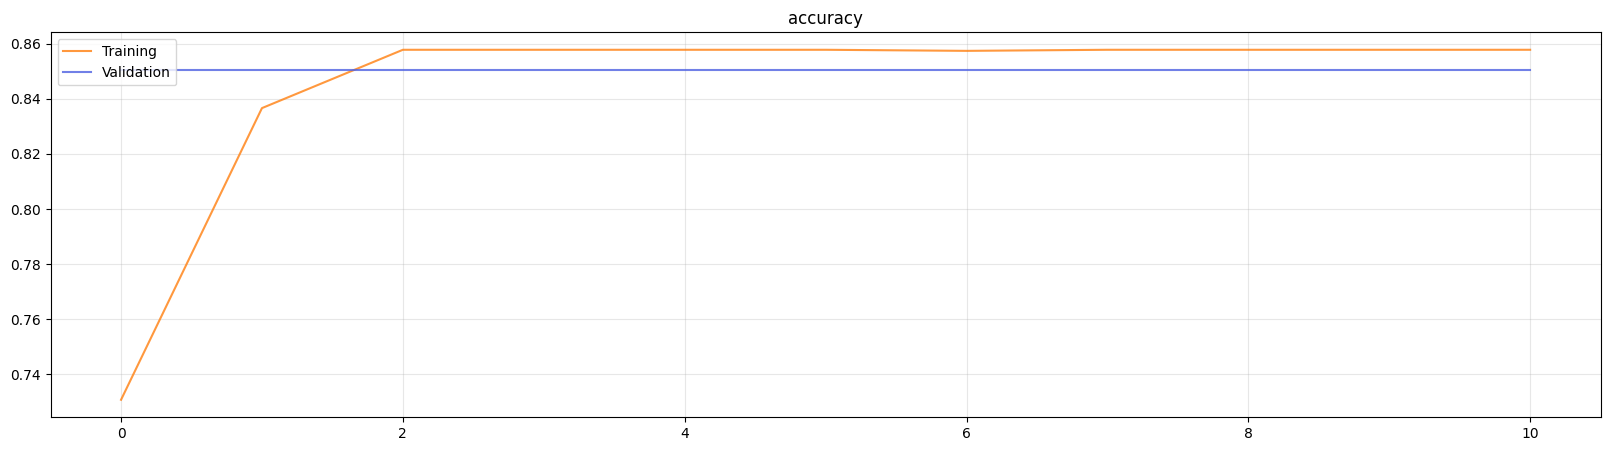

INFO:tensorflow:Assets written to: ../../local_saved_models/ensemble-5/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/ensemble-5/assets


In [55]:
ensemble_model.append(train_ensemble_classifier(5,input_shape))

Class in i:  (200,)
Class in others:  (2988,)


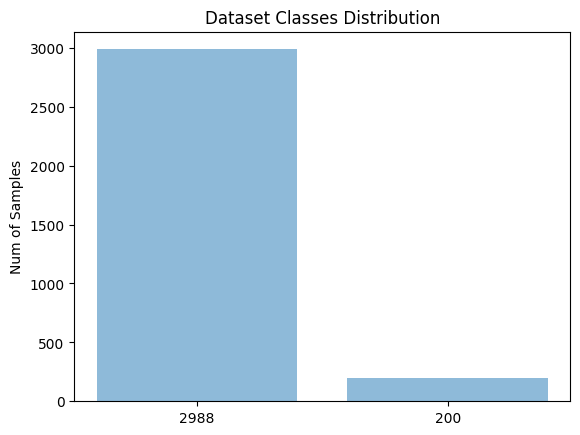

Data Augmentation with data distribution
Data distribution = [0.45, 0.2]
Class Size :  156, generating: 2250
2184 images generated


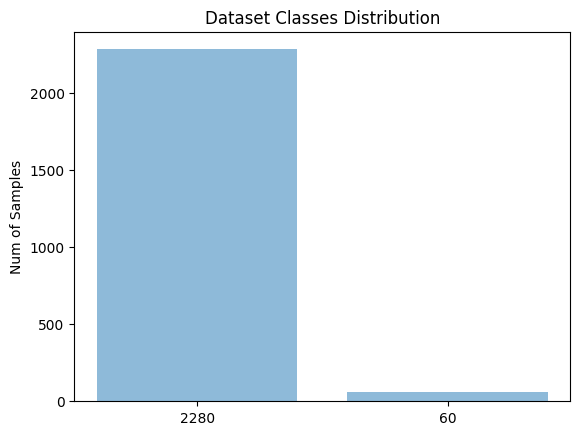

Model: "ensemble-6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 Layer0_conv0 (Conv2D)       (None, 96, 96, 32)        4736      
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 Layer1_conv0 (Conv2D)       (None, 48, 48, 64)        51264     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 Layer2_conv0 (Conv2D)       (None, 24, 24, 128)       7

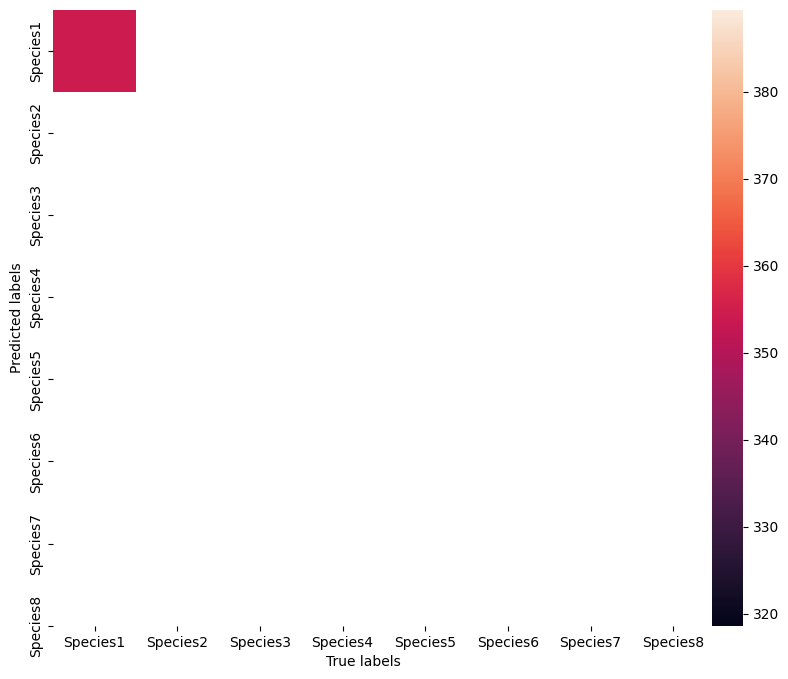

BABABA


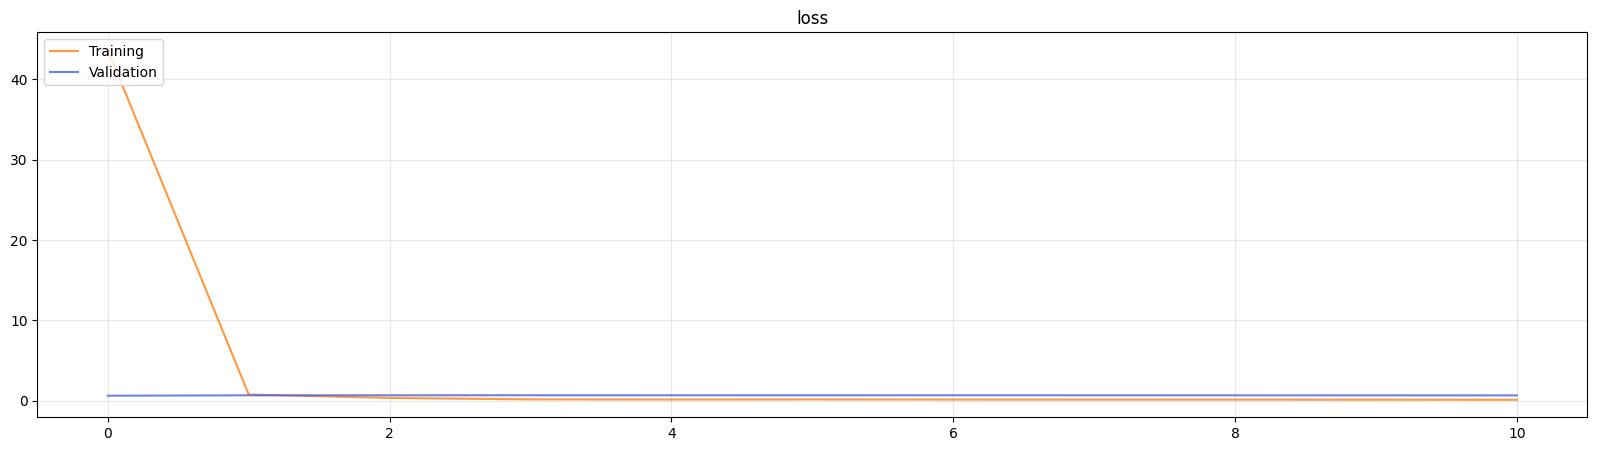

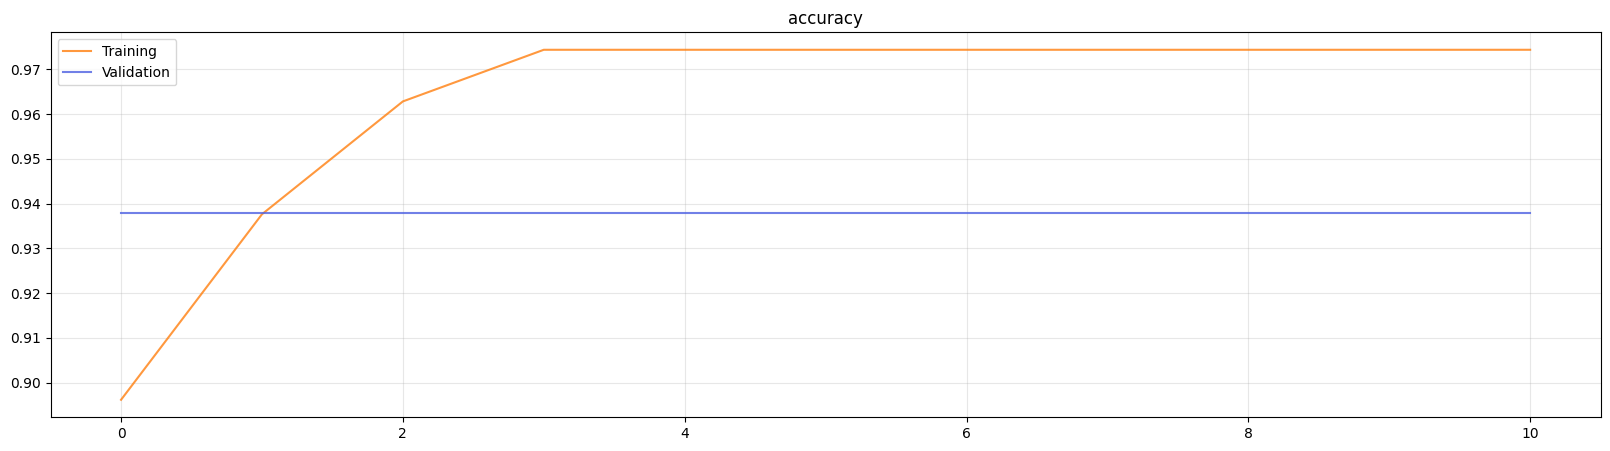

INFO:tensorflow:Assets written to: ../../local_saved_models/ensemble-6/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/ensemble-6/assets


In [56]:
ensemble_model.append(train_ensemble_classifier(6,input_shape))

Class in i:  (483,)
Class in others:  (2705,)


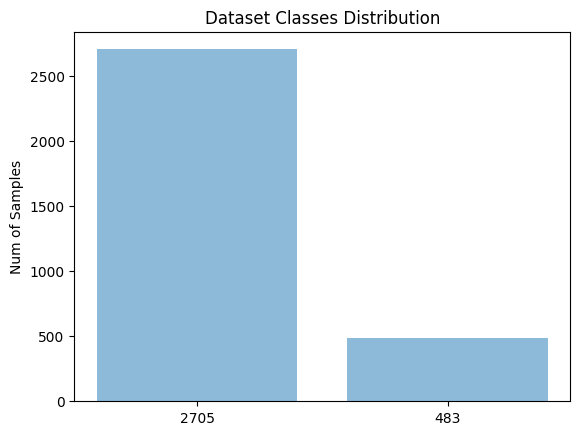

Data Augmentation with data distribution
Data distribution = [0.45, 0.2]
Class Size :  375, generating: 2250
2195 images generated


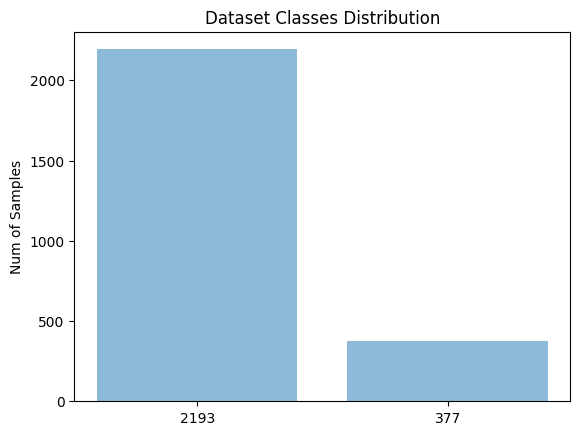

Model: "ensemble-7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 Layer0_conv0 (Conv2D)       (None, 96, 96, 32)        4736      
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 Layer1_conv0 (Conv2D)       (None, 48, 48, 64)        51264     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 Layer2_conv0 (Conv2D)       (None, 24, 24, 128)       7

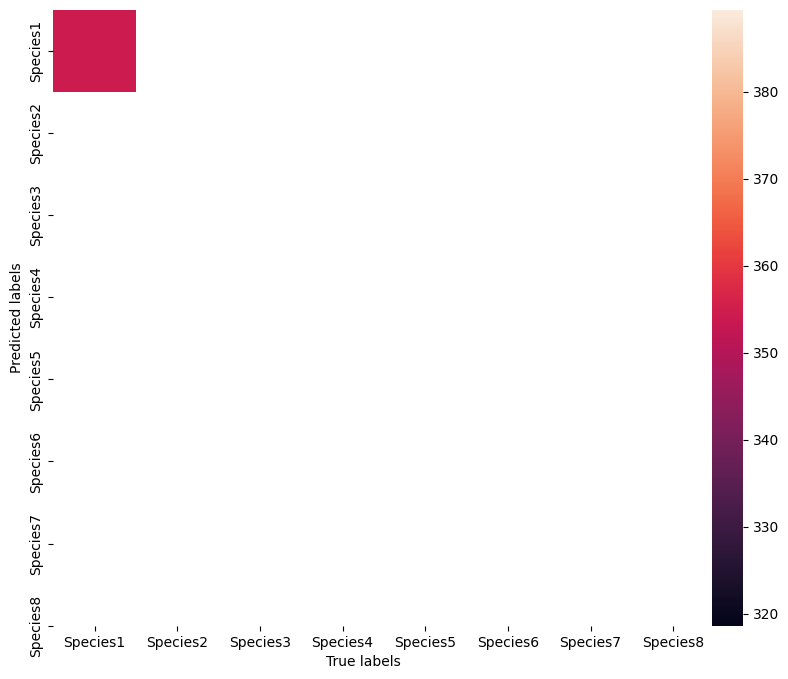

BABABA


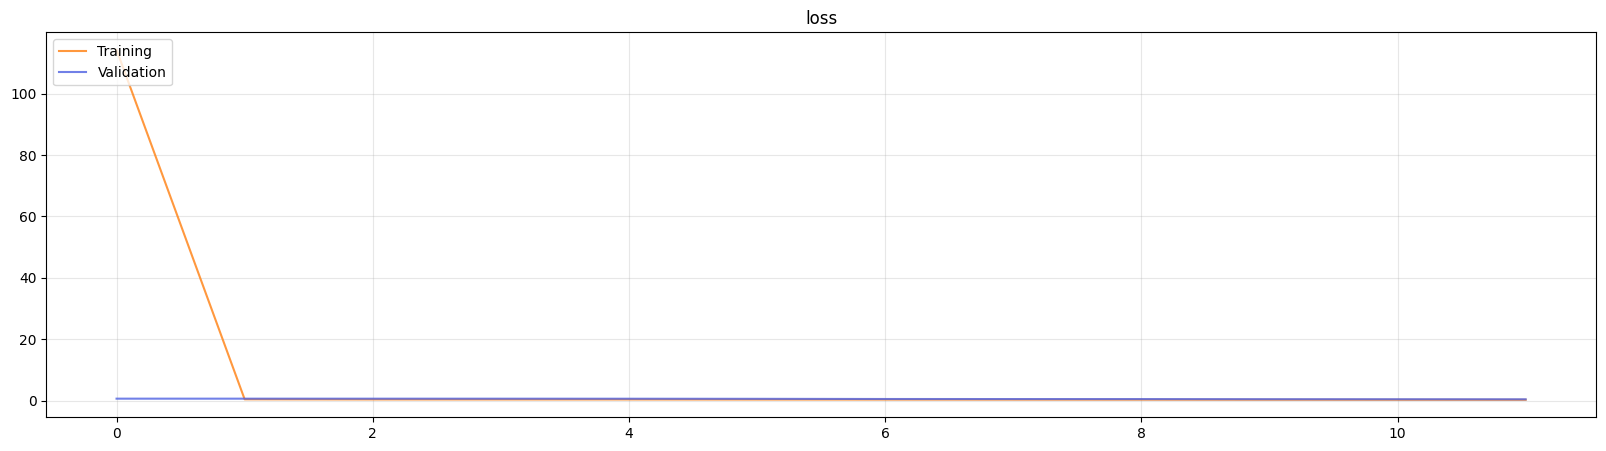

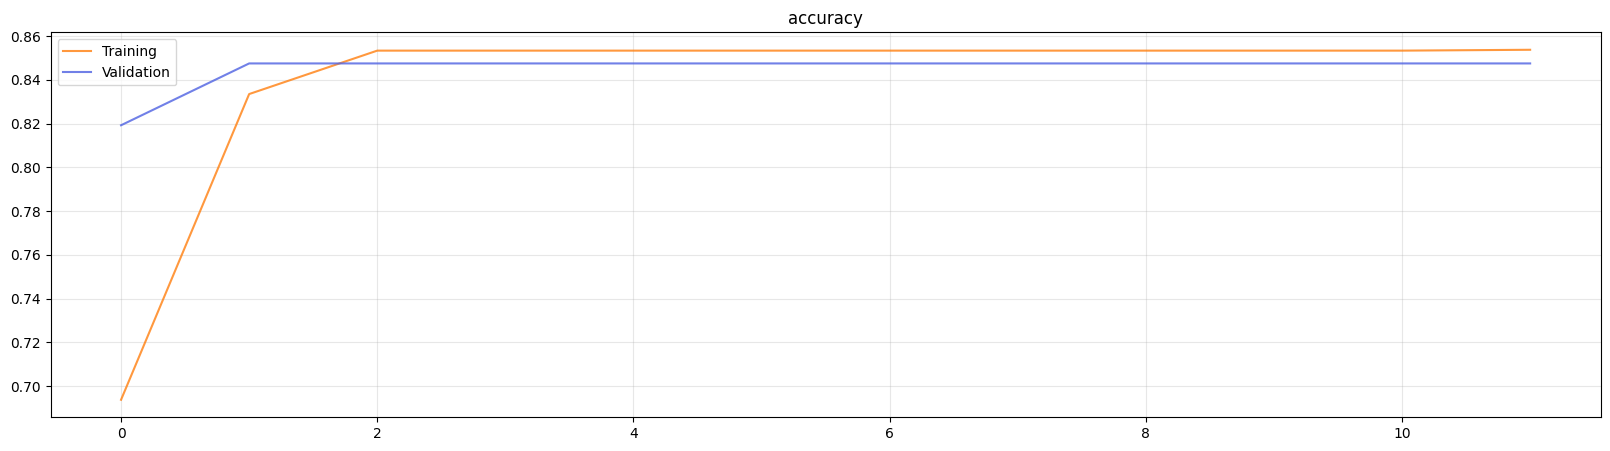

INFO:tensorflow:Assets written to: ../../local_saved_models/ensemble-7/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/ensemble-7/assets


In [57]:
ensemble_model.append(train_ensemble_classifier(7,input_shape))

Class in i:  (457,)
Class in others:  (2731,)


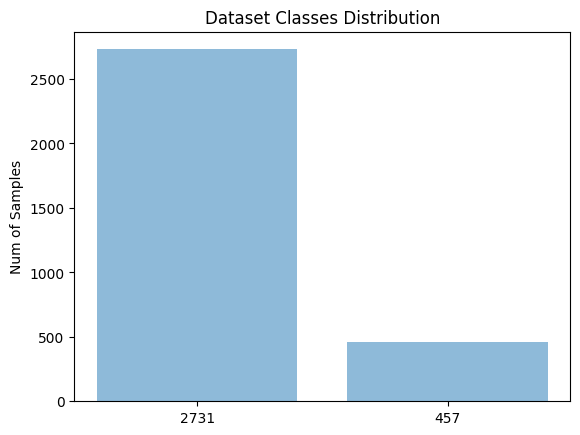

Data Augmentation with data distribution
Data distribution = [0.45, 0.2]
Class Size :  355, generating: 2250
2095 images generated


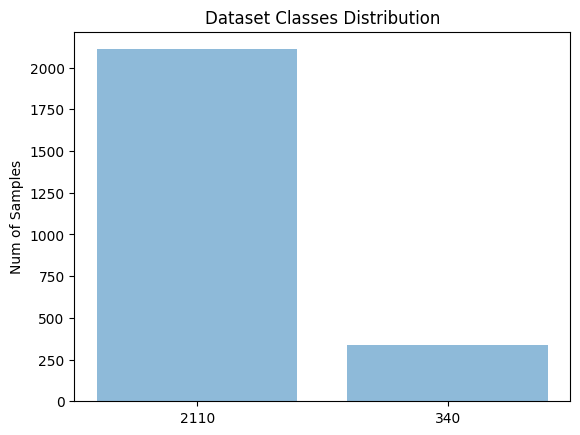

Model: "ensemble-8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 Layer0_conv0 (Conv2D)       (None, 96, 96, 32)        4736      
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 Layer1_conv0 (Conv2D)       (None, 48, 48, 64)        51264     
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 Layer2_conv0 (Conv2D)       (None, 24, 24, 128)       7

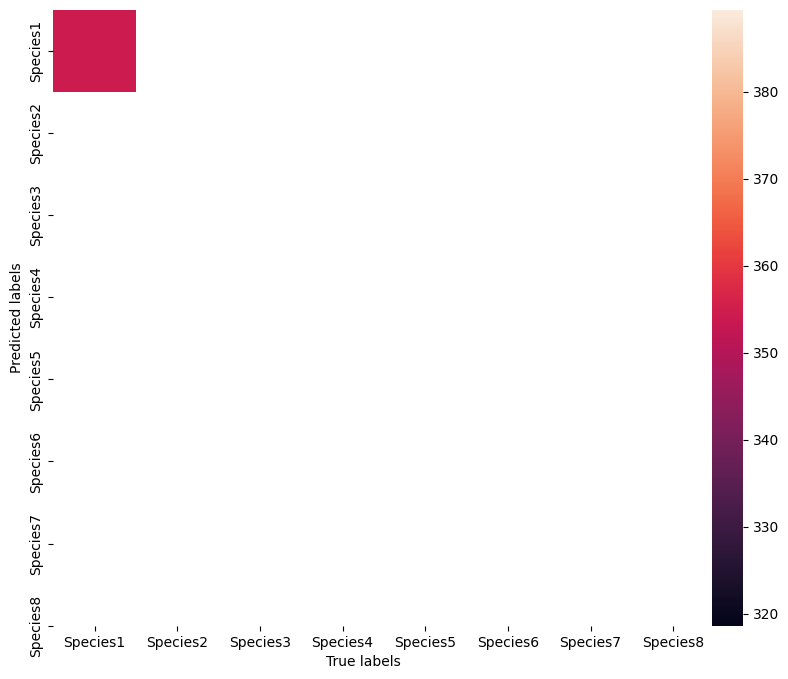

BABABA


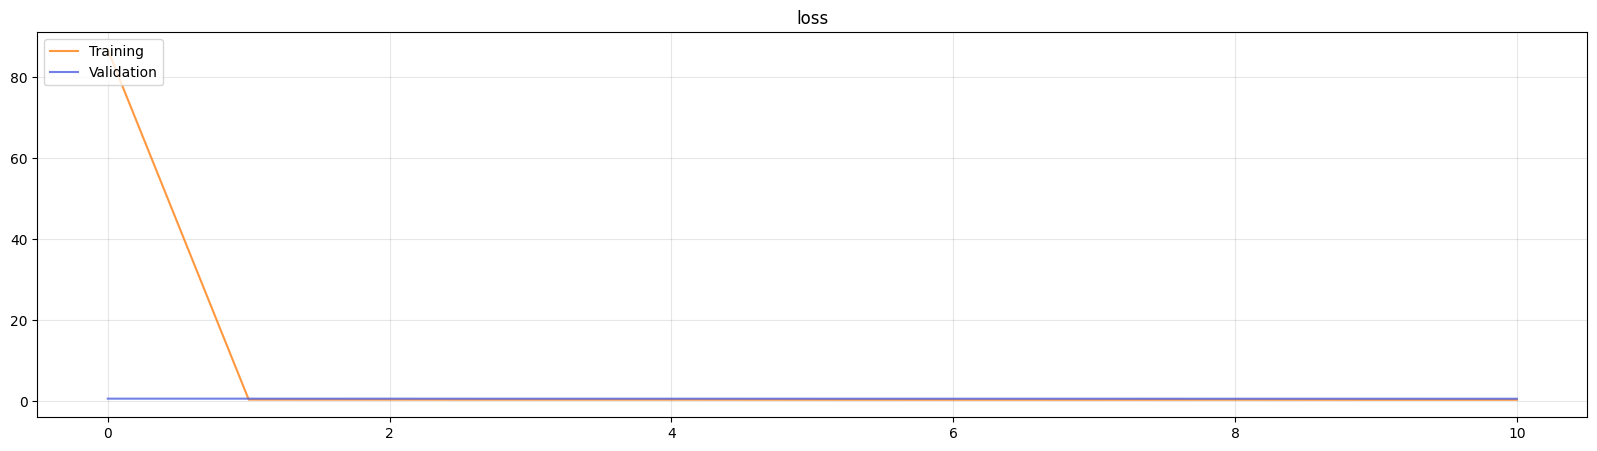

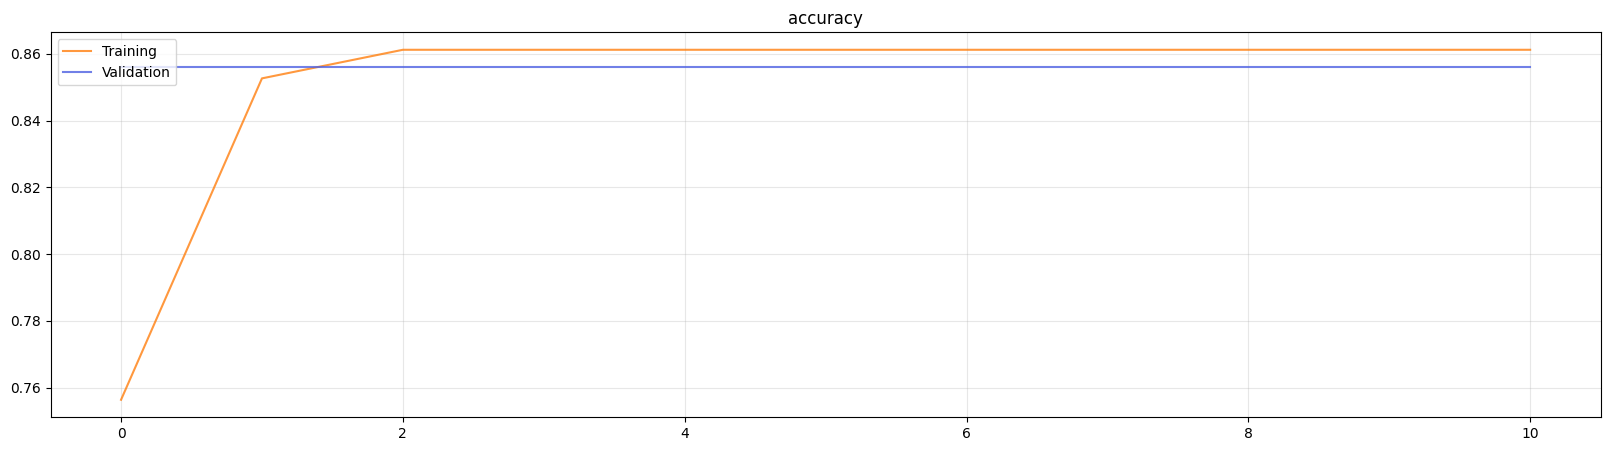

INFO:tensorflow:Assets written to: ../../local_saved_models/ensemble-8/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/ensemble-8/assets


In [58]:
ensemble_model.append(train_ensemble_classifier(8,input_shape))

# Prediction Function for Ensemble Model

In [71]:
def ensemble_predict(ensemble_model,X):
    #predictions = np.empty((1,X.shape[0],8))
    #[[0.3,0.7],[0.5,0.8],[0.3,0,5]] -> prediction of a class [pos neg]
    #[[0.3],[0.5],[0.3]]             -> prediction of a class [only pos]
    #now i have an array of pos for each class
    # [[0.3],[0.5],[0.3]],[[0.3],[0.5],[0.3]],[[0.3],[0.5],[0.3]] ->want the argmax for each of them
    
    predictions = []
    i=0
    for model_i in ensemble_model:
        i=i+1
        pred_i = model_i.predict(X)
        #pred_i = pred_i[:,0] #Take only the (Is class i percentage, we dont want the "Is not" percentage)
        print("PRED - ",i,pred_i)
        #pred_i = pred_i.reshape((1,8)) #1D array with 8 class pos prediction
        predictions.append(pred_i) # Each array appended has all predictions of a specific class binary predictor

    out = np.argmax(np.vstack(predictions), axis=0)    
        
    
    return out # Find the result of each pred_i[1]

In [72]:
out = ensemble_predict(ensemble_model,X_test)

12/12 [==============================] - 0s 14ms/step
PRED -  1 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]


12/12 [==============================] - 0s 12ms/step
PRED -  4 [[1.79315754e-03]
 [1.09403450e-02]
 [1.22417335e-03]
 [3.05514026e-04]
 [1.96797308e-02]
 [1.06157018e-02]
 [1.58353336e-02]
 [1.56477913e-02]
 [7.82985613e-03]
 [4.80350759e-03]
 [3.48555408e-02]
 [4.59613185e-03]
 [5.02952328e-03]
 [1.75652280e-02]
 [3.36760795e-03]
 [3.03904098e-02]
 [3.59703787e-03]
 [3.70558389e-02]
 [5.09146880e-03]
 [2.26211897e-03]
 [3.83939482e-02]
 [5.34805516e-03]
 [6.19059568e-03]
 [1.96277071e-02]
 [8.51515401e-03]
 [1.09678395e-02]
 [1.50144808e-02]
 [3.60768922e-02]
 [2.33524712e-04]
 [4.16719392e-02]
 [1.62736736e-02]
 [2.63840612e-03]
 [9.22939274e-03]
 [6.24897145e-03]
 [2.01111636e-03]
 [6.71405997e-03]
 [3.30623332e-03]
 [1.64860878e-02]
 [1.02061303e-02]
 [4.97718016e-03]
 [1.31364434e-03]
 [6.51221210e-03]
 [4.23197309e-03]
 [6.02997188e-03]
 [1.29887117e-02]
 [1.00474870e-02]
 [9.85875167e-03]
 [2.35354970e-03]
 [2.95828399e-03]
 [4.46200604e-03]
 [7.98645336e-03]
 [9.95059591e-03]


12/12 [==============================] - 0s 11ms/step
PRED -  6 [[1.37790852e-25]
 [1.02803598e-20]
 [4.46070256e-18]
 [9.18717334e-29]
 [7.79641616e-17]
 [2.96746015e-17]
 [4.85781005e-18]
 [4.58139928e-20]
 [2.78370672e-25]
 [1.37106212e-12]
 [3.56735759e-20]
 [4.27319188e-17]
 [8.45204426e-20]
 [1.20056015e-16]
 [3.60308669e-24]
 [9.31974470e-16]
 [2.99287477e-13]
 [4.02549772e-19]
 [1.82223367e-23]
 [7.00770562e-22]
 [8.96910046e-10]
 [1.12364111e-13]
 [1.75337247e-18]
 [1.04570293e-11]
 [2.32646815e-14]
 [7.26018150e-26]
 [2.02634930e-34]
 [1.24915772e-11]
 [1.77465601e-26]
 [1.23080170e-20]
 [6.85997754e-13]
 [2.59415889e-15]
 [4.48702061e-25]
 [6.00361923e-22]
 [4.71591880e-18]
 [3.06920868e-19]
 [6.16218570e-23]
 [5.35560608e-20]
 [2.15377648e-16]
 [9.54910628e-21]
 [4.30776837e-35]
 [6.81843428e-19]
 [4.70411760e-24]
 [4.79125628e-09]
 [1.02639224e-16]
 [1.73541262e-14]
 [9.47321896e-18]
 [2.19354939e-18]
 [6.12923618e-19]
 [2.62245636e-15]
 [1.72827007e-19]
 [7.39089008e-22]


12/12 [==============================] - 0s 11ms/step
PRED -  8 [[0.06761097]
 [0.11404316]
 [0.12063025]
 [0.04308951]
 [0.1366526 ]
 [0.1154696 ]
 [0.15993579]
 [0.09514924]
 [0.07084484]
 [0.12173717]
 [0.14341049]
 [0.14362618]
 [0.15470535]
 [0.12266231]
 [0.08011903]
 [0.12303995]
 [0.13324068]
 [0.11279324]
 [0.13365912]
 [0.1135098 ]
 [0.20578732]
 [0.19659024]
 [0.11652984]
 [0.17323948]
 [0.17806892]
 [0.08421594]
 [0.08891556]
 [0.2824868 ]
 [0.05700658]
 [0.13833642]
 [0.17617969]
 [0.12090629]
 [0.10643652]
 [0.11528296]
 [0.23652561]
 [0.08329941]
 [0.12951101]
 [0.08264895]
 [0.12446071]
 [0.09351233]
 [0.04468195]
 [0.12465756]
 [0.15795094]
 [0.12483565]
 [0.12839912]
 [0.17318816]
 [0.11179981]
 [0.16046722]
 [0.11748289]
 [0.15477751]
 [0.10840789]
 [0.11142121]
 [0.21754038]
 [0.11687583]
 [0.19460899]
 [0.06585683]
 [0.16532566]
 [0.12456851]
 [0.1786921 ]
 [0.10481432]
 [0.12052376]
 [0.13046537]
 [0.13913433]
 [0.06818365]
 [0.13775562]
 [0.13816373]
 [0.19517778

In [62]:
out

array([6, 6, 1, 6, 1, 1, 7, 6, 6, 7, 1, 6, 7, 1, 1, 1, 1, 6, 1, 6, 1, 7,
       1, 1, 1, 6, 6, 7, 7, 7, 1, 7, 1, 1, 7, 1, 6, 6, 1, 1, 6, 1, 7, 1,
       6, 1, 6, 7, 6, 1, 6, 1, 7, 6, 7, 6, 6, 7, 6, 1, 1, 1, 1, 6, 7, 1,
       7, 6, 7, 1, 6, 6, 1, 6, 1, 1, 6, 1, 6, 1, 1, 7, 1, 1, 7, 6, 6, 6,
       1, 1, 1, 6, 1, 1, 6, 1, 7, 7, 6, 1, 1, 1, 6, 1, 1, 6, 6, 1, 7, 1,
       1, 7, 6, 1, 1, 6, 7, 1, 6, 6, 7, 1, 6, 6, 7, 6, 1, 1, 7, 7, 7, 1,
       1, 1, 6, 1, 1, 1, 6, 1, 6, 6, 7, 6, 7, 6, 1, 1, 1, 7, 6, 6, 1, 7,
       6, 1, 7, 6, 1, 1, 1, 7, 6, 1, 6, 1, 6, 1, 1, 1, 1, 1, 1, 1, 6, 7,
       1, 6, 1, 6, 1, 6, 6, 6, 1, 1, 6, 6, 6, 7, 6, 7, 6, 1, 1, 1, 7, 6,
       1, 1, 7, 1, 7, 1, 1, 6, 6, 6, 1, 1, 7, 6, 7, 6, 1, 6, 6, 6, 1, 6,
       6, 7, 6, 1, 1, 1, 6, 6, 7, 1, 6, 1, 1, 1, 7, 6, 7, 6, 7, 1, 1, 1,
       6, 1, 1, 6, 7, 1, 7, 1, 7, 1, 6, 1, 7, 6, 1, 6, 6, 6, 1, 7, 7, 6,
       6, 7, 7, 6, 6, 1, 7, 1, 7, 7, 6, 7, 6, 6, 6, 1, 1, 1, 6, 1, 7, 6,
       6, 1, 6, 6, 1, 7, 7, 1, 1, 6, 1, 1, 1, 6, 7,

# Test the Full Ensemble Model

In [ ]:

ensemble_model = test_ensemble_full(ensemble_model)


In [ ]:
def load_ensemble_model():
  ensemble_model = []
  for class_index in range(1,8):
    model_name = "ensemble-" + str(class_index)
    model_i = model_helper.load_model(model_name)
    ensemble_model.append(model_i)

  return ensemble_model

In [ ]:
ensemble_model = load_ensemble_model()